# AIML421, Assignement 1, Corvin Idler, Student ID 300598312, idlercorv@myvuw.ac.nz
#PART I

## Importing needed modules + "housekeeping" settings

In [ ]:
import pickle
from tabulate import tabulate

import pandas as pd
import numpy as np
import numpy.random as rng 
np.set_printoptions(precision=2)

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline 



## Read input data and set things up for next step
Making sure all data sets are pandas data frames and the last column is always the class variable. Also setting up some lists (data sets, algorithms, names, parameter ranges) to allow looping over all of them later on. Inspired by: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [ ]:
#downloading the data sets from the internet
steel_plates_fault = pd.read_csv('https://www.openml.org/data/get_csv/1592296/php9xWOpn')
ionosphere = pd.read_csv('https://www.openml.org/data/get_csv/59/dataset_59_ionosphere.arff')
banknotes =pd.read_csv('https://www.openml.org/data/get_csv/1586223/php50jXam')
iris =pd.read_csv('https://www.openml.org/data/get_csv/61/dataset_61_iris.arff')

# making a fake data set here and turn it into data frame with class info in last column
X, y = make_classification(n_features=20, n_redundant=0, n_informative=5, n_clusters_per_class=1)
X += 4.0 * np.random.uniform(size=X.shape)
fakedataset = pd.DataFrame(np.c_[X, y.astype(int)])
fakedataset = fakedataset.astype({20: int})

algonames = ["k nearest neighbours", "Gaussian Naive Bayes", "Perceptron (logistic regression)", "Decision tree (DT)", 
         "Gradient Boosted DTs", "Random Forest", "Neural Net"
         ]
classifiers = [KNeighborsClassifier(),GaussianNB(),LogisticRegression(max_iter=500),DecisionTreeClassifier(),GradientBoostingClassifier(),
              RandomForestClassifier(),MLPClassifier(max_iter=500)
              ]
param_grid_list = [[{"n_neighbors":np.arange(1, 6)}],[{"var_smoothing":[1e-9,1e-5,1e-1]}],[{"C":[.1,.5,1.0,2.0, 5.0]}],
                   [{"max_depth":np.arange(1,11)}], [{"max_depth":np.arange(1,11)}], [{"max_depth":np.arange(1,11)}],
                    [{"alpha":[1e-5, 1e-3,0.1, 10.0]}]]

datasetnames = ["steel_plates_fault","ionosphere","banknotes","fakedataset"]

mydatasets = [steel_plates_fault,ionosphere,banknotes,fakedataset]



## Looping over datasets and algorithms
I loop over all algorithm and all datasets.I do 250 iteration of 50:50 cross-validation while performing a grid-search over the parameter ranges as per the assignement. In the end I store the results in a list for visualistion later on

In [ ]:
resultlist=[]

for ds, dn in zip(mydatasets,datasetnames):
  # preprocess dataset, split into training and test part
  X = ds.iloc[:, :-1]
  y = ds.iloc[:, -1]
  #Standardize features by removing the mean and scaling to unit variance
  X = StandardScaler().fit_transform(X)
  #loop over all algorithms
  for clf, cn, pr in zip(classifiers, algonames, param_grid_list):
    #perform flowing operation 250 times = cross validation with 50:50 split
    cv = ShuffleSplit(n_splits=250, test_size=0.5, random_state=4223) 
    #do a grid search over the specified parameter ranges and score by accuracy
    cvresults=GridSearchCV(estimator=clf,param_grid=pr,cv=cv,verbose=0,n_jobs=-1,scoring='accuracy').fit(X,y)
    #store result in list
    resultlist.append([dn,cn,cvresults])




I stored pickle file with the grid search results under "https://github.com/econdatatech/econdatatech/raw/main/resultlist.pkl"
As the number crunching is the most time consuming part, I thought there is merit in making the results of that step available.

In [ ]:
#store results on gdrive (I used google colab as environment)
#with open("/content/drive/MyDrive/resultlist.pkl", "wb") as fp:   #Pickling
#  pickle.dump(resultlist, fp)
#load results from gdrive
#with (open("/content/drive/MyDrive/resultlist.pkl", "rb")) as openfile:
#  resultlist=pickle.load(openfile)

# stored pickle file as well under: "https://github.com/econdatatech/econdatatech/raw/main/resultlist.pkl"
#resultlist=pd.read_pickle("https://github.com/econdatatech/econdatatech/raw/main/resultlist.pkl")



#Visualizing results in boxplots
I loop over all algorithms and find corresponding results in my result list and display results in 10 rows of main plots (algorithms) consisting of of 4 columns of subplots (datasets) with a box-plot in each column (250x 50:50 cross-validation of parameter grid search)

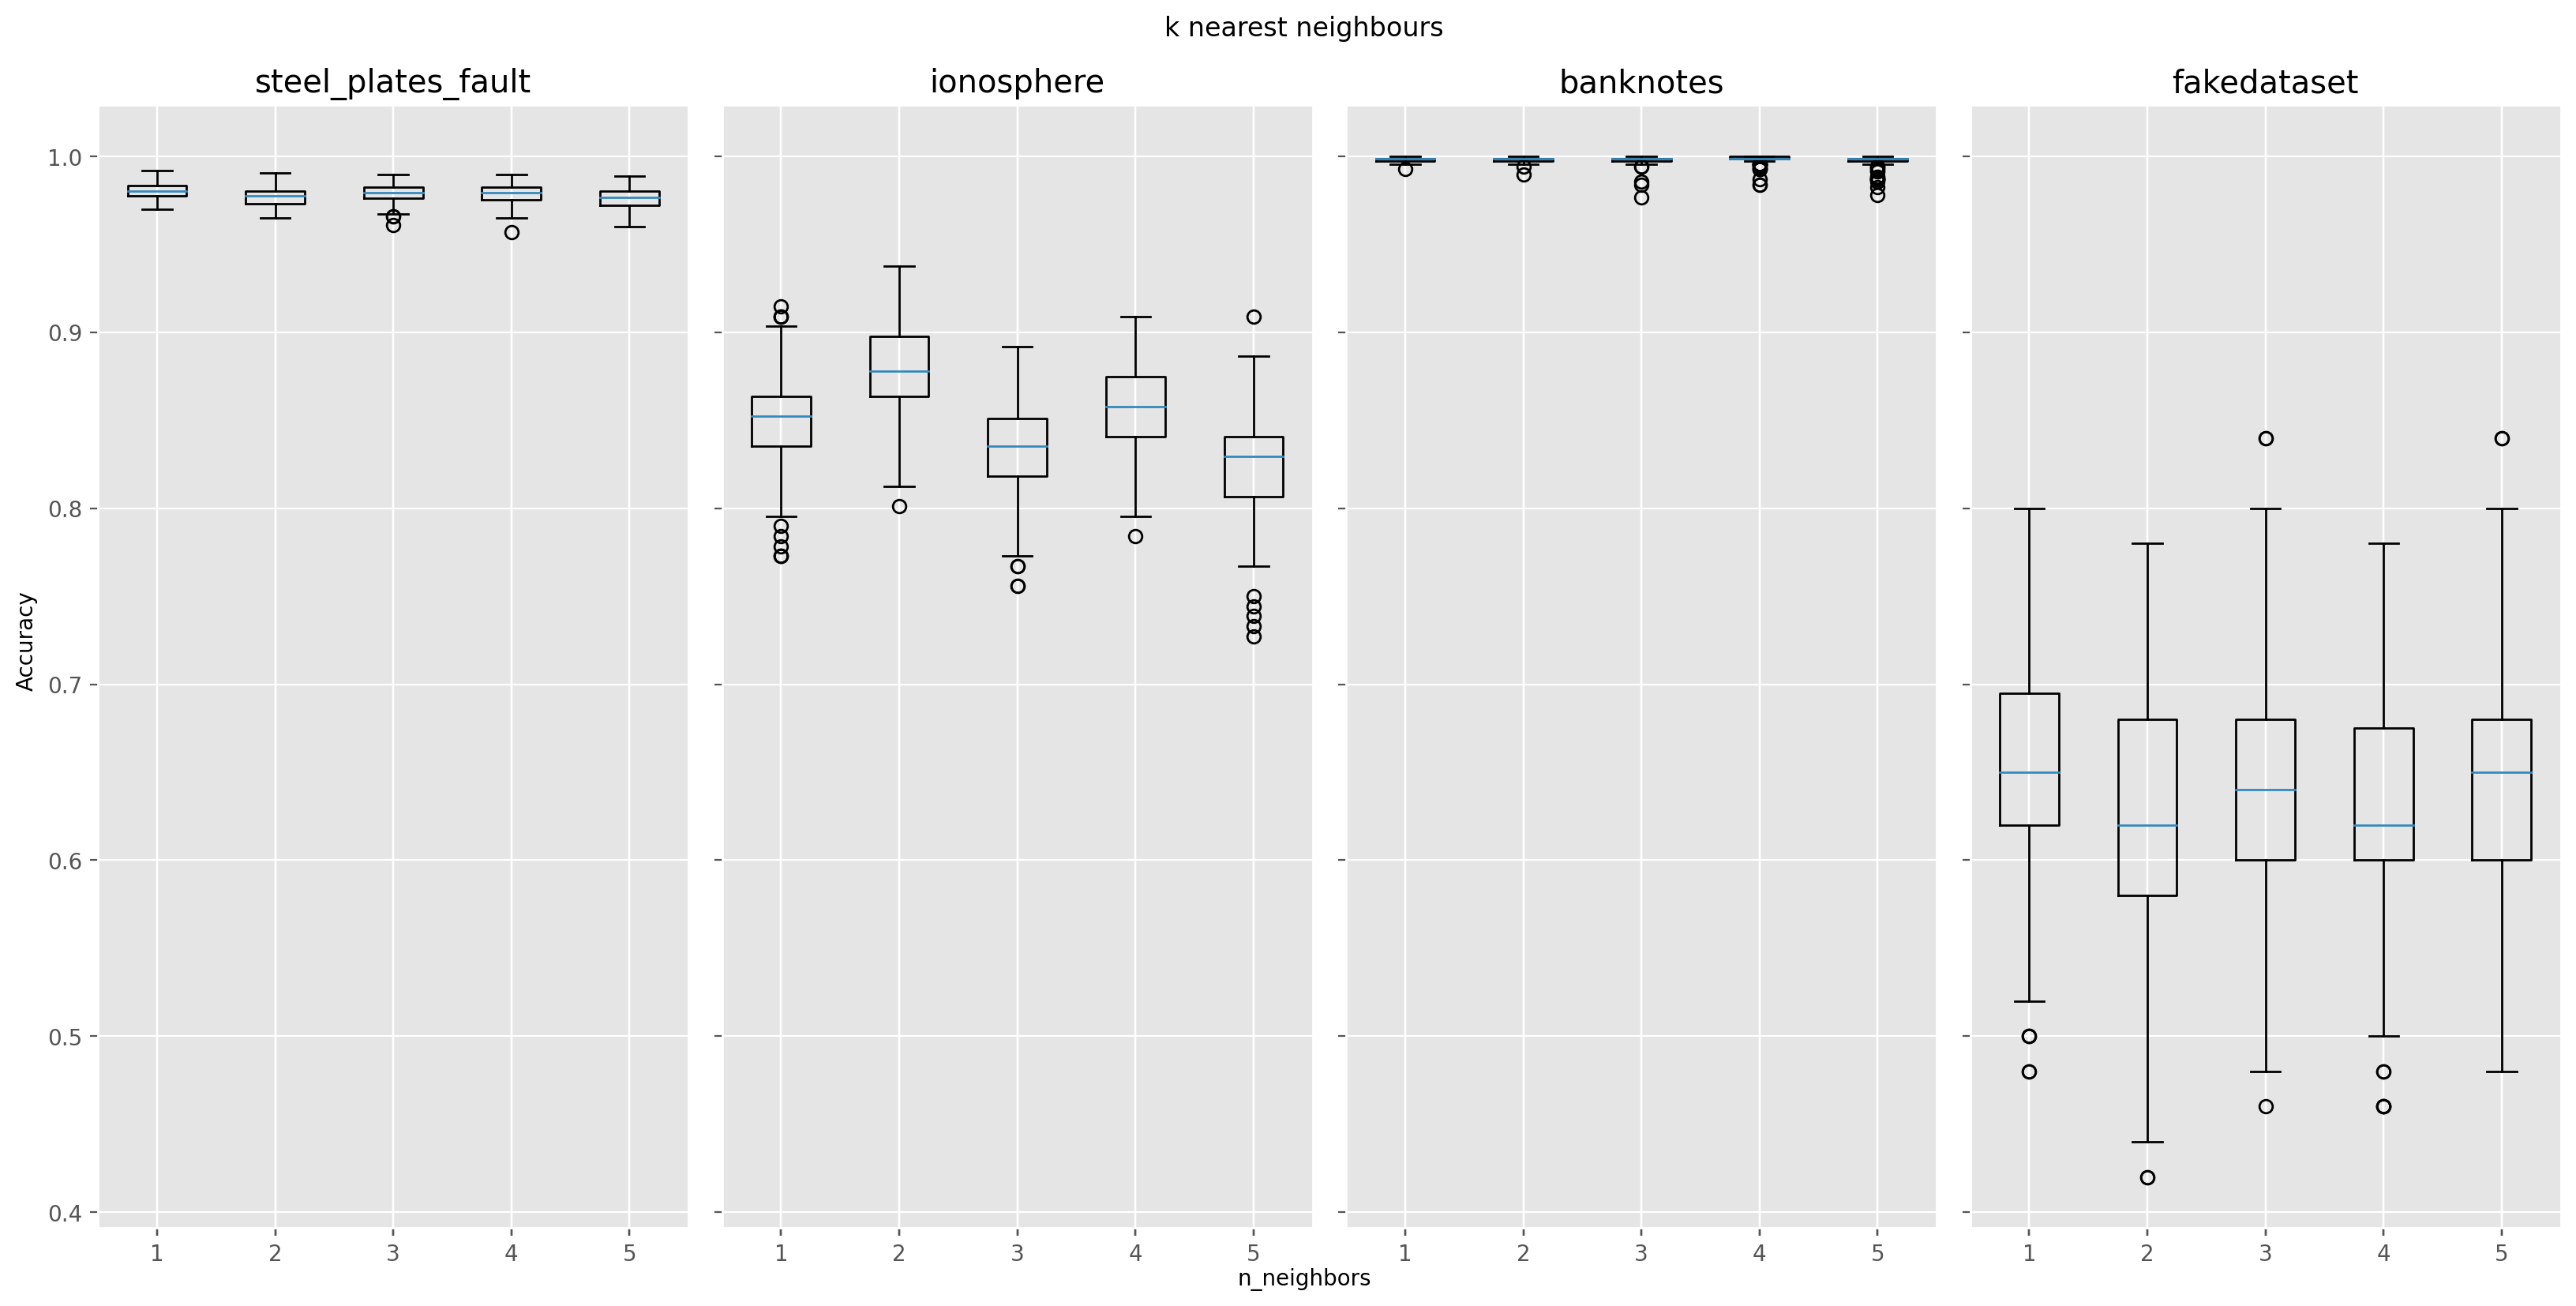

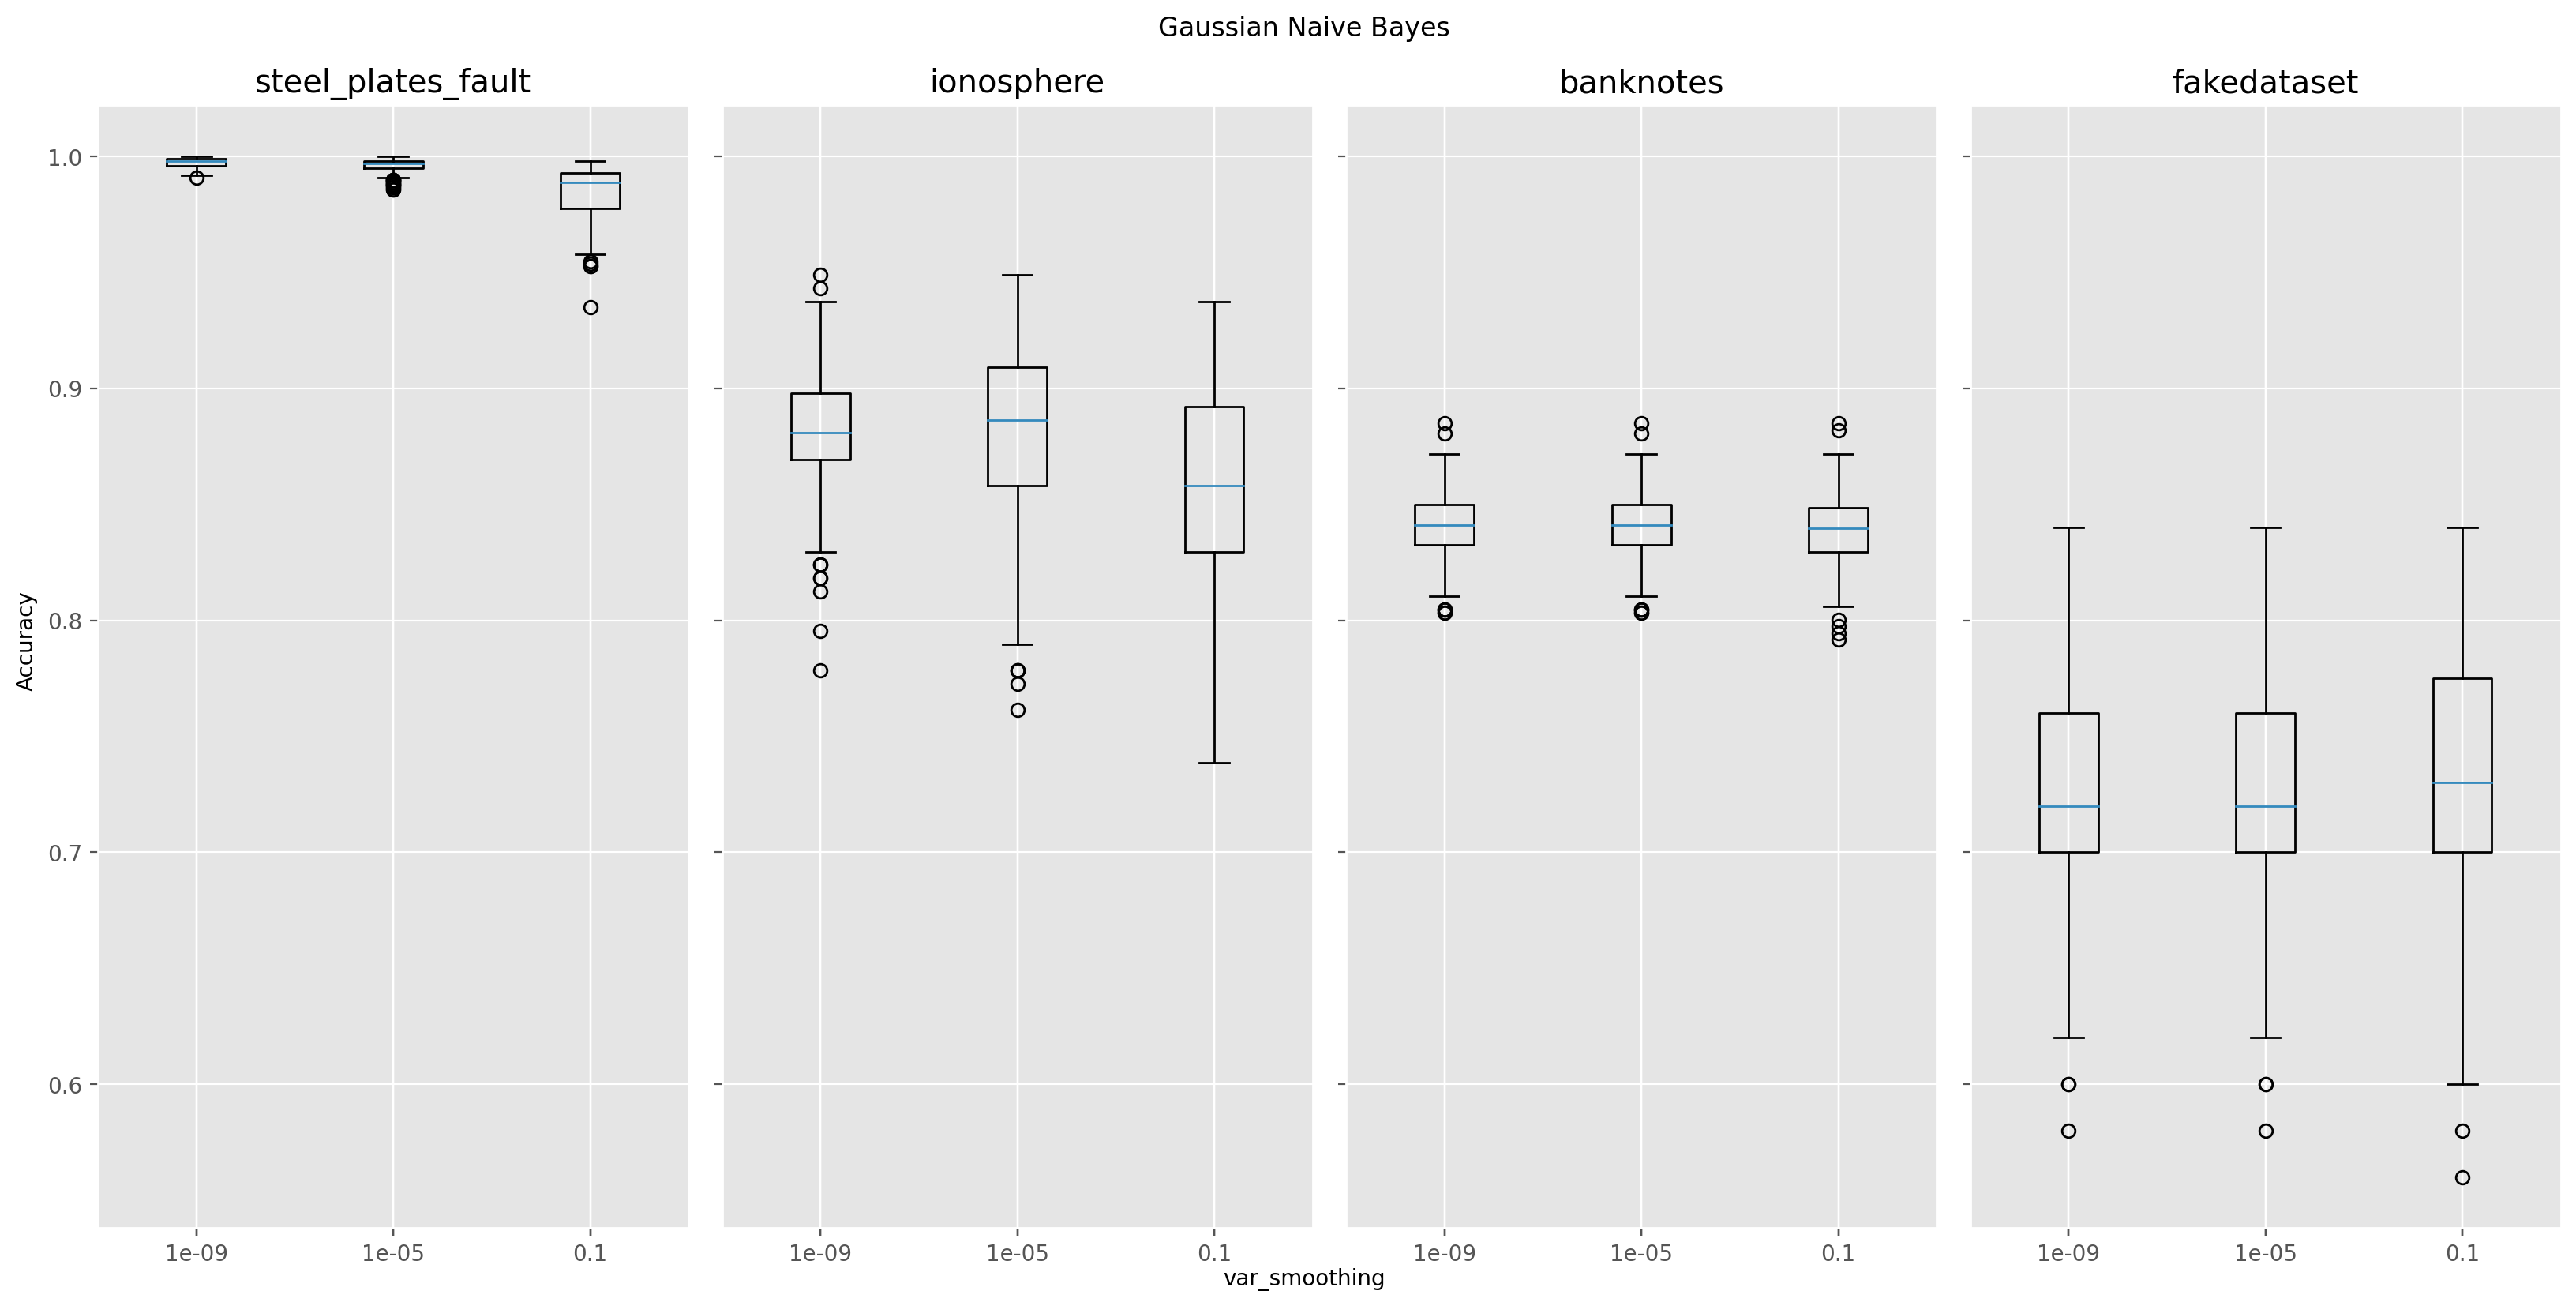

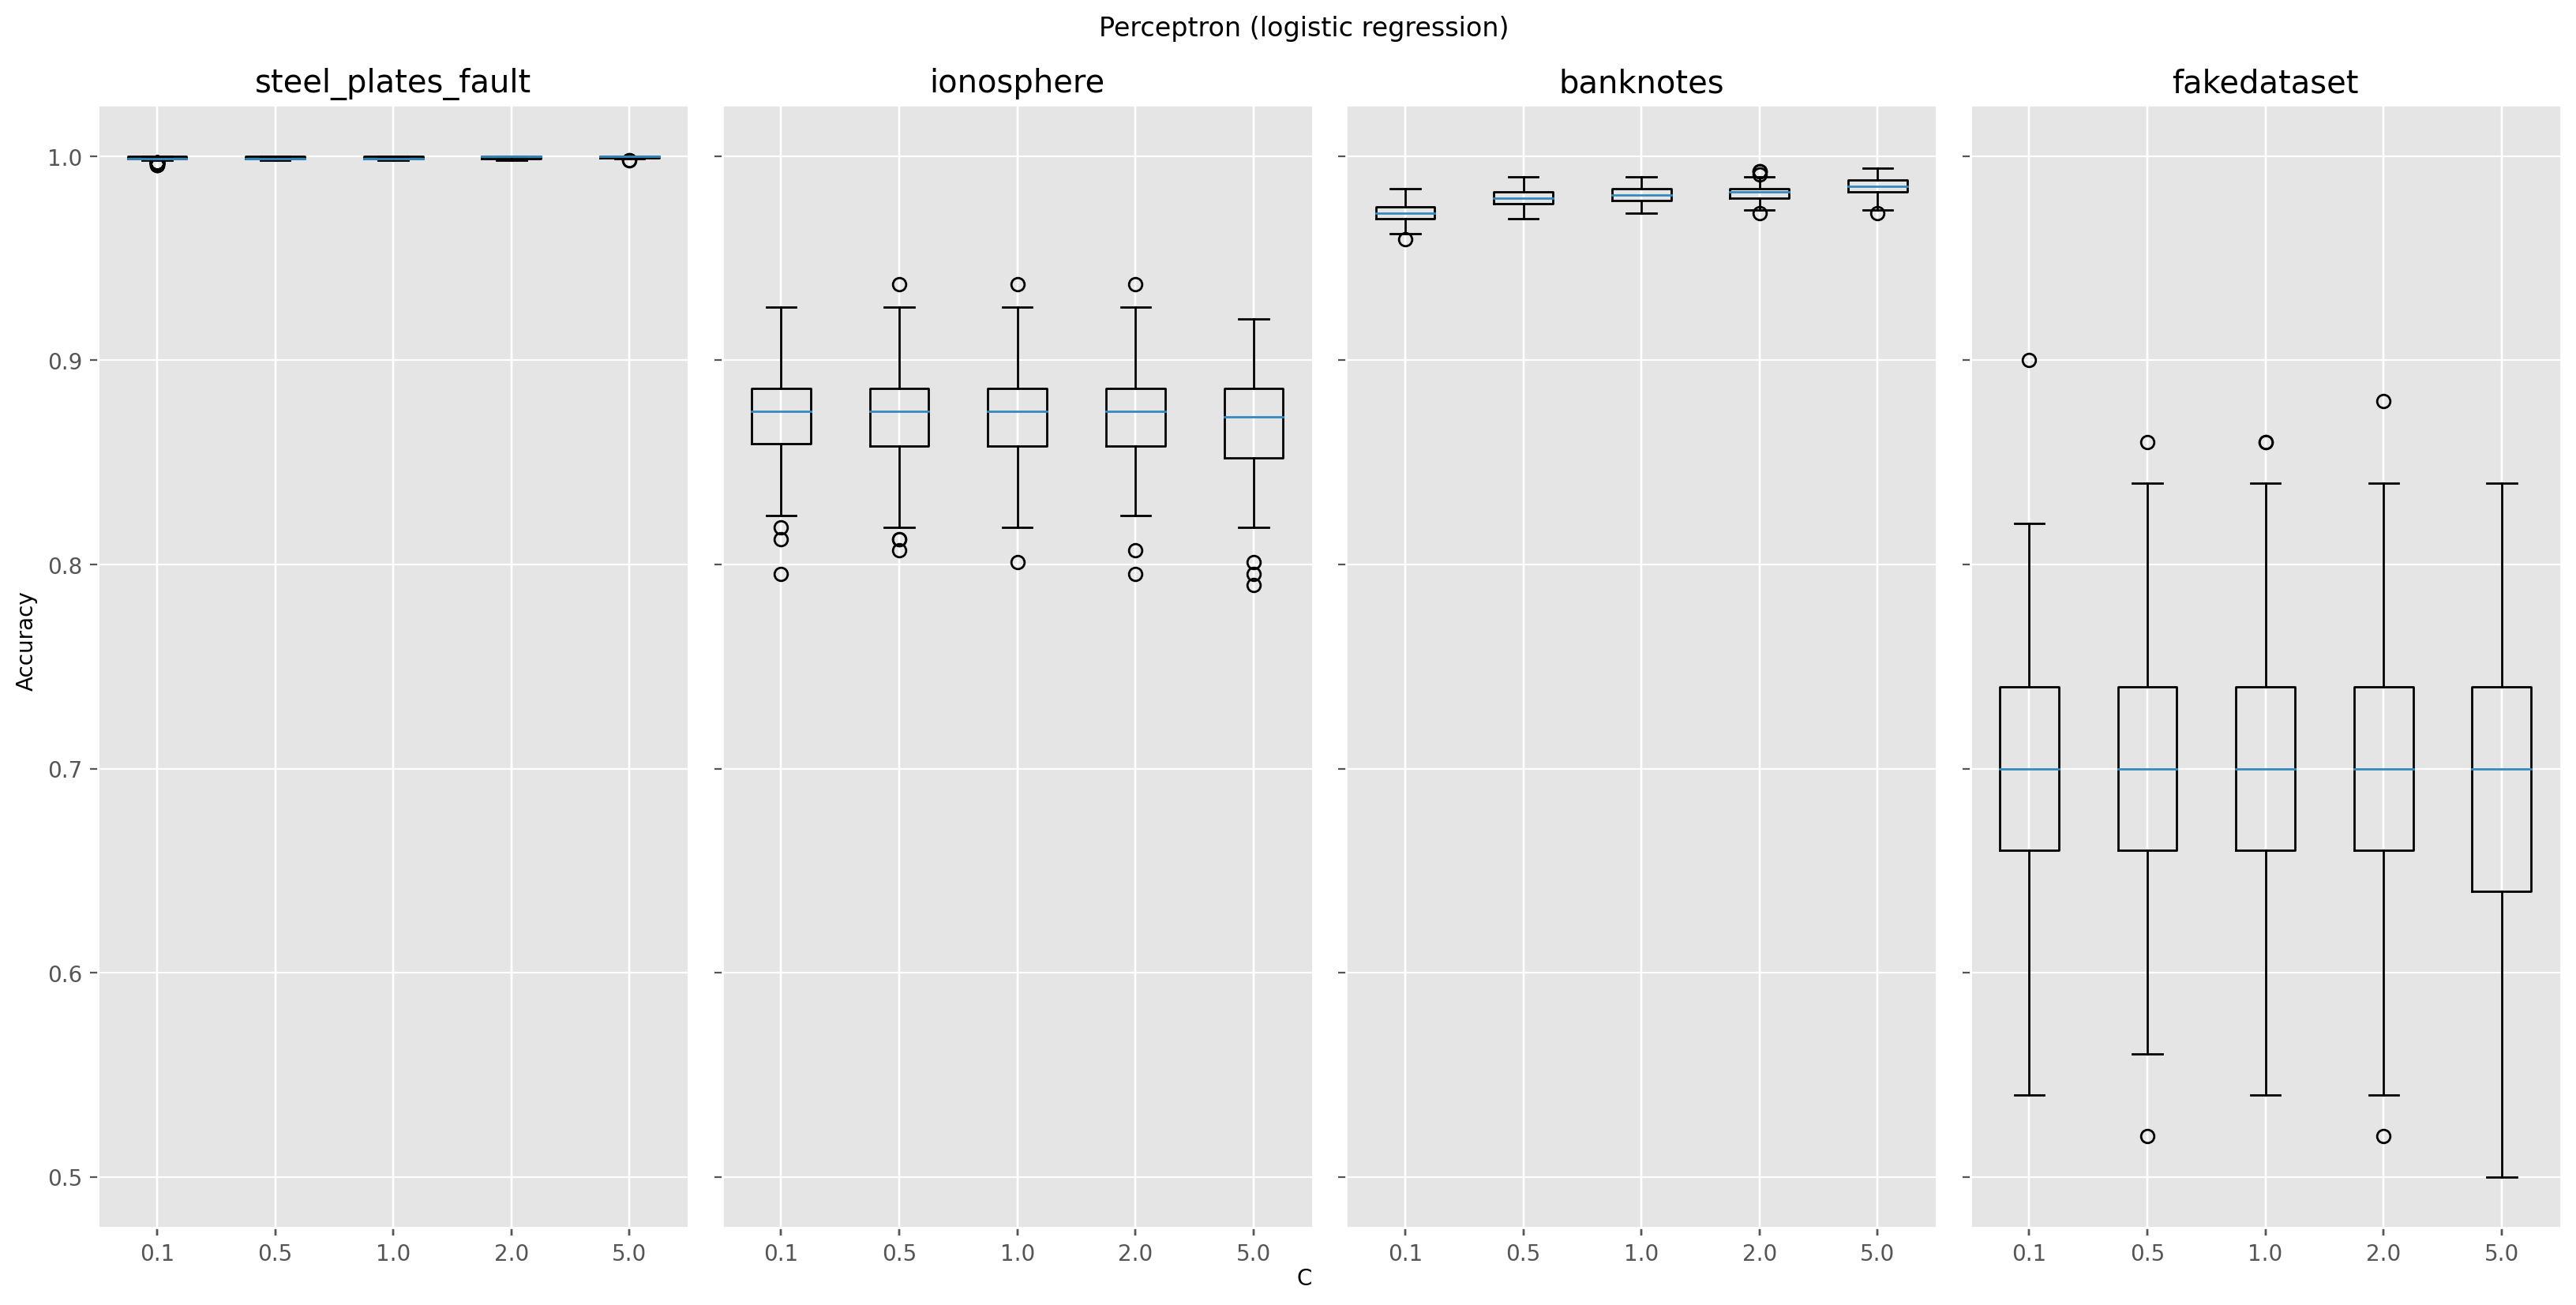

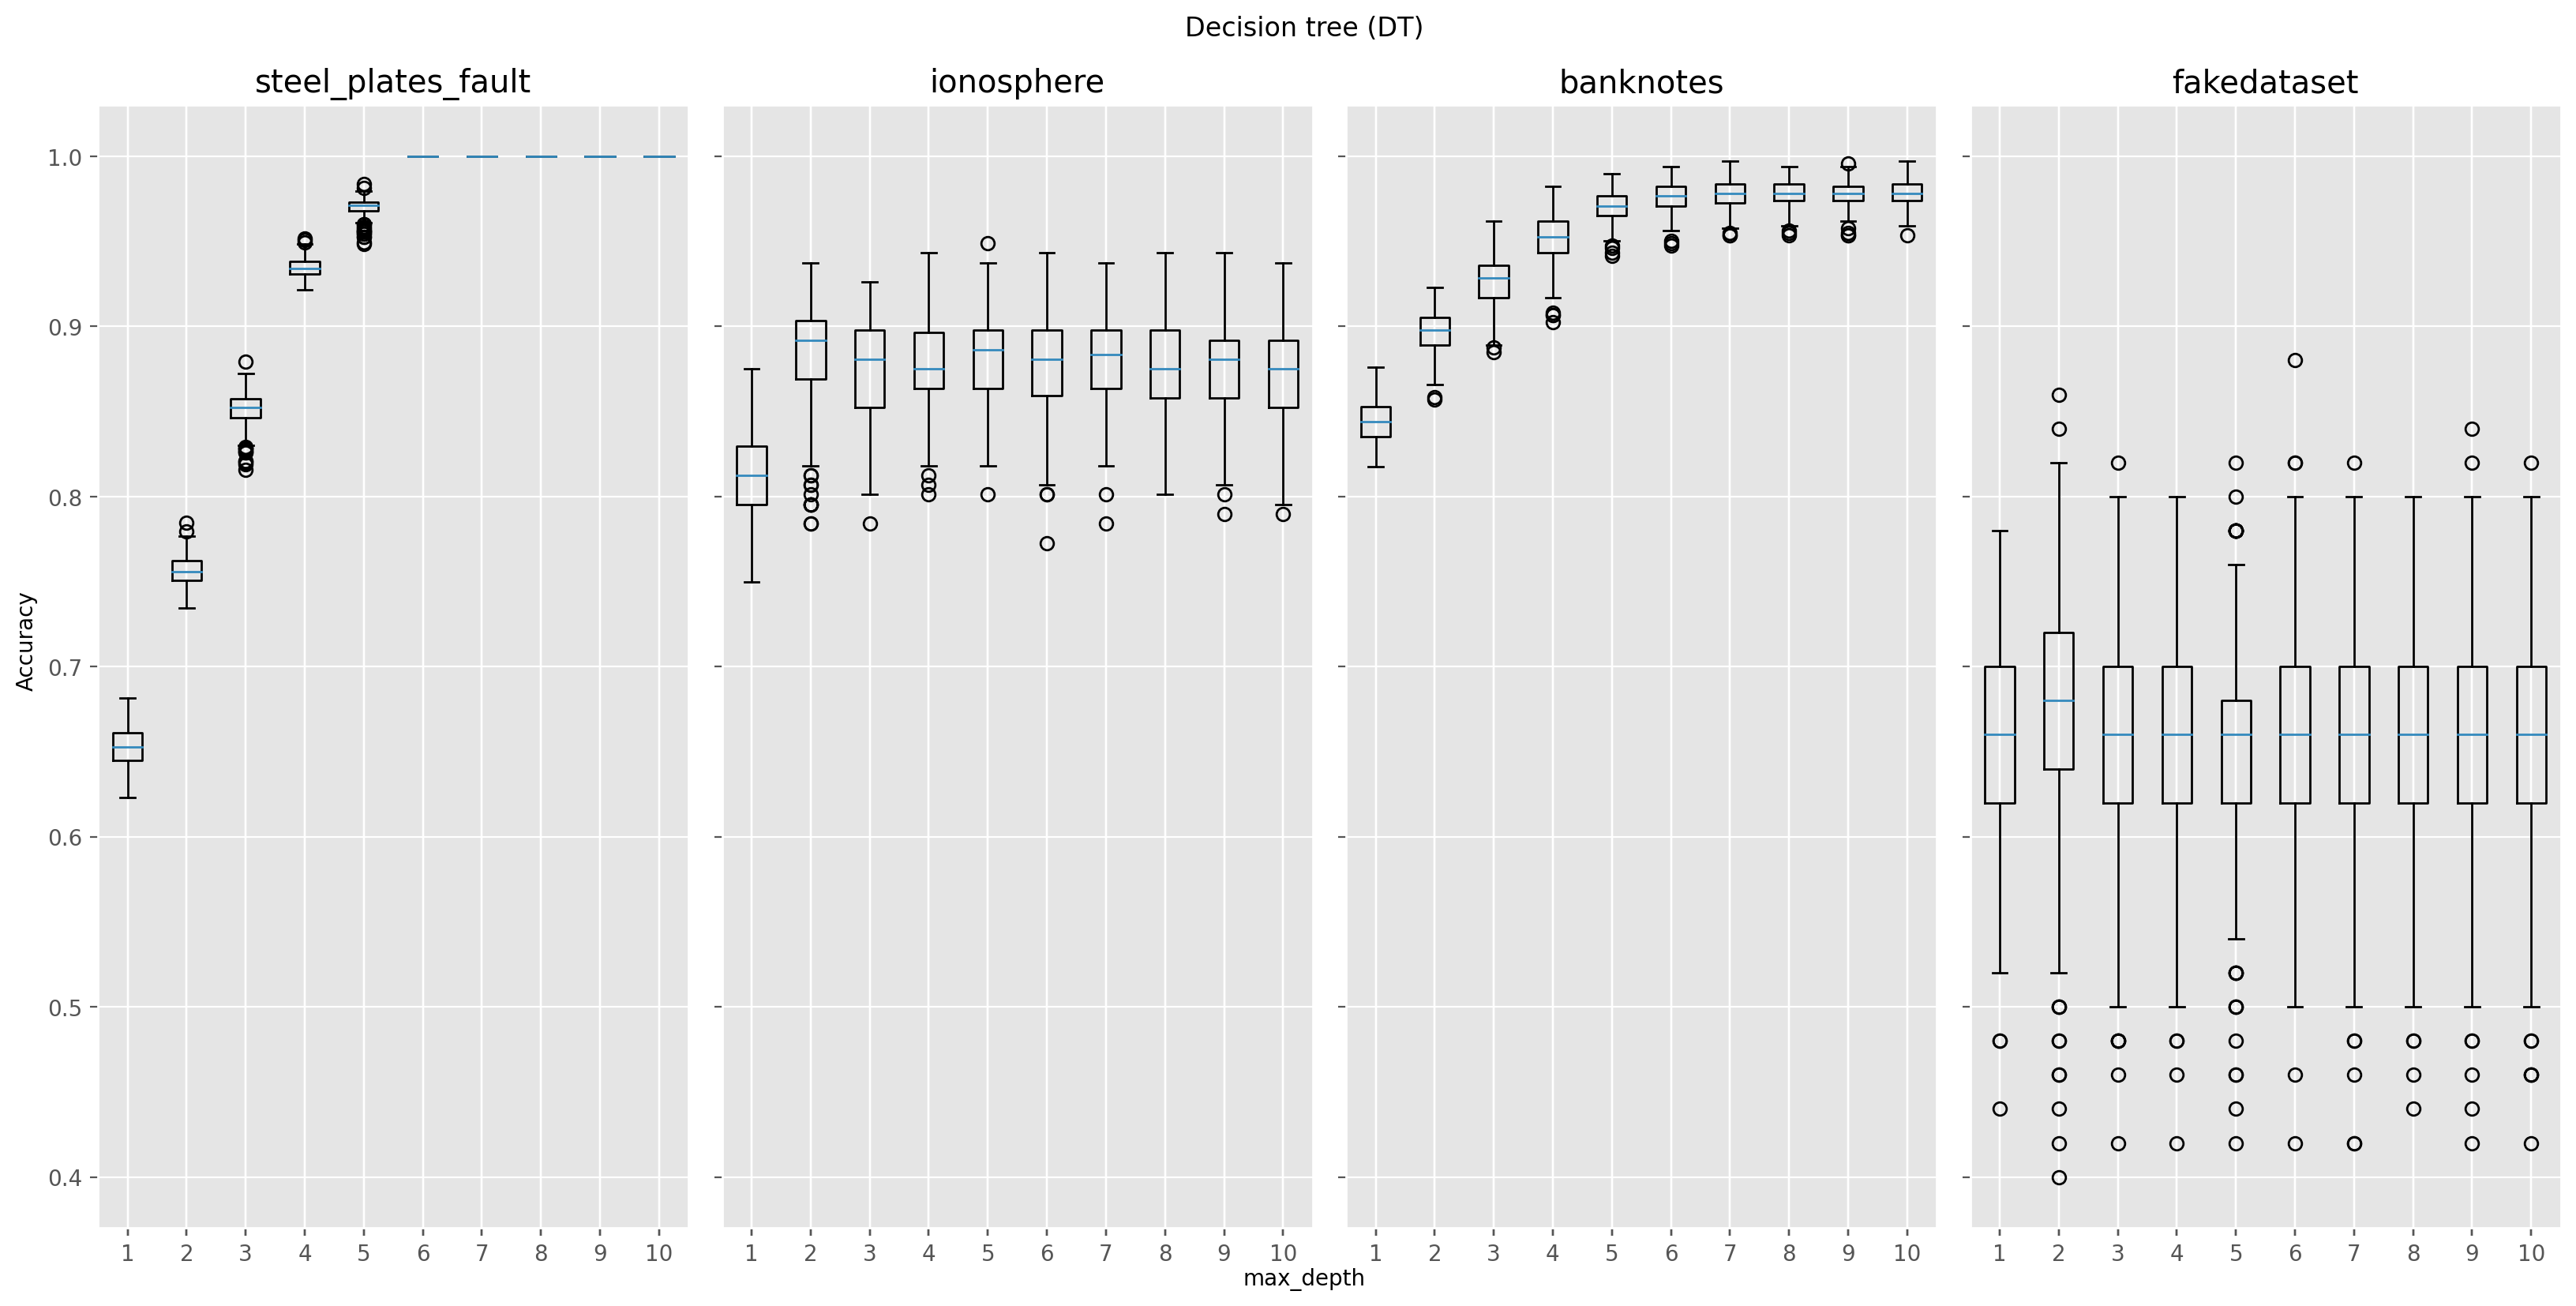

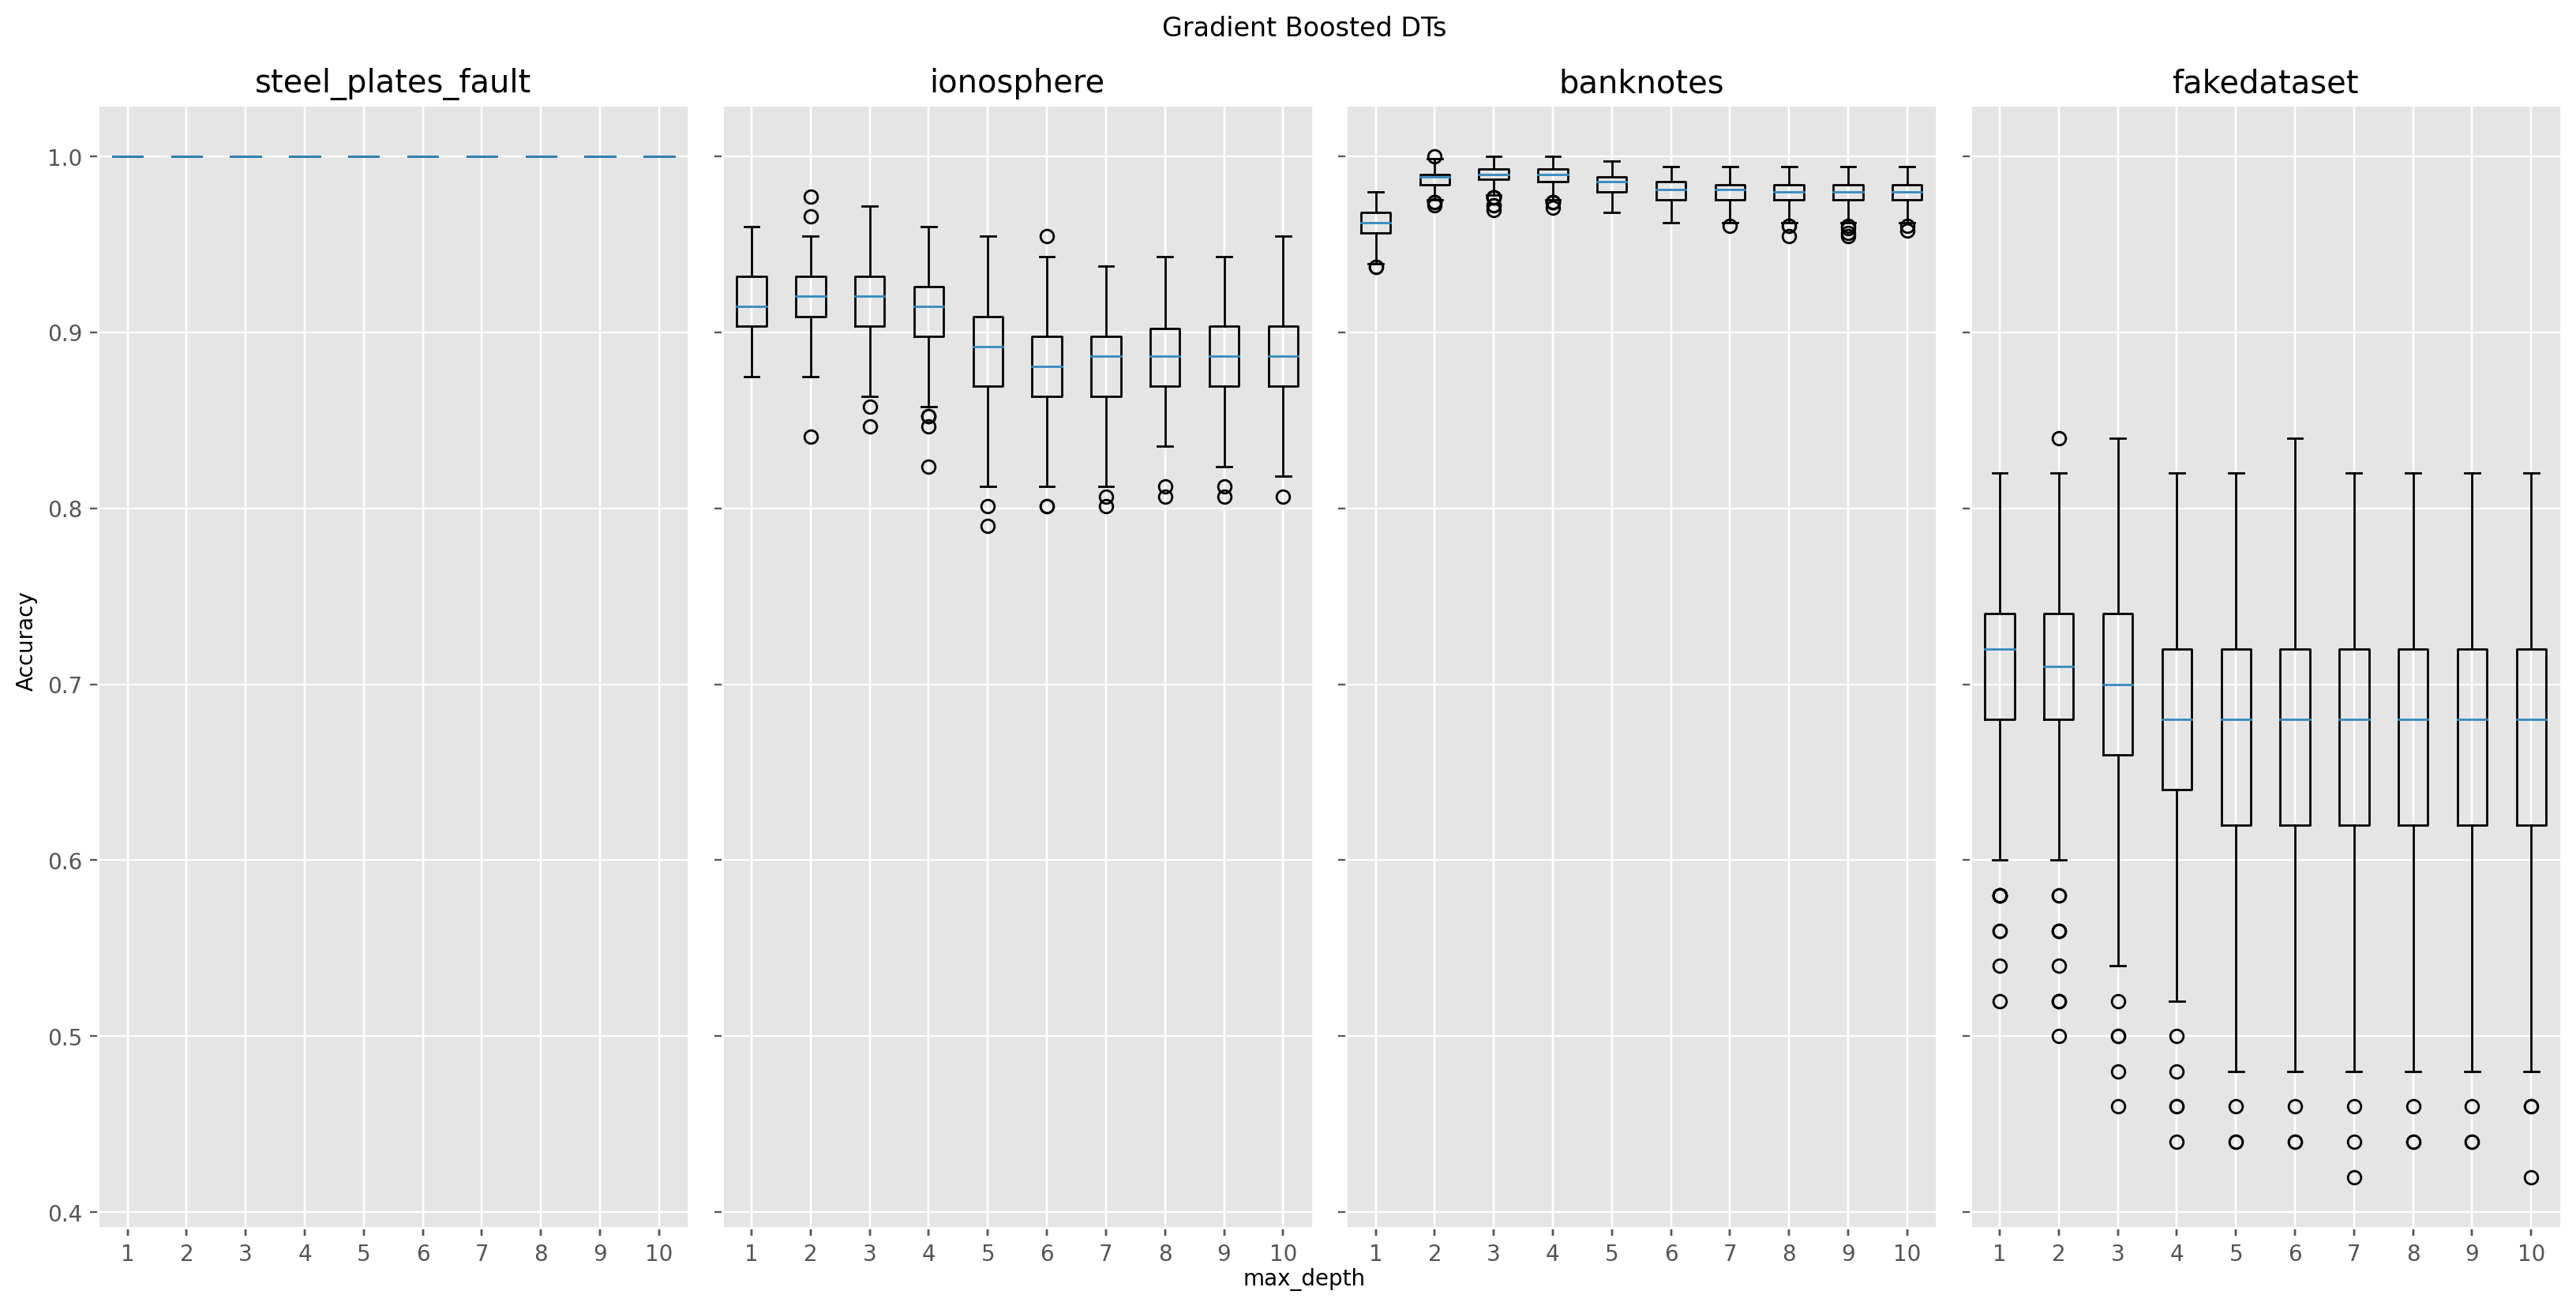

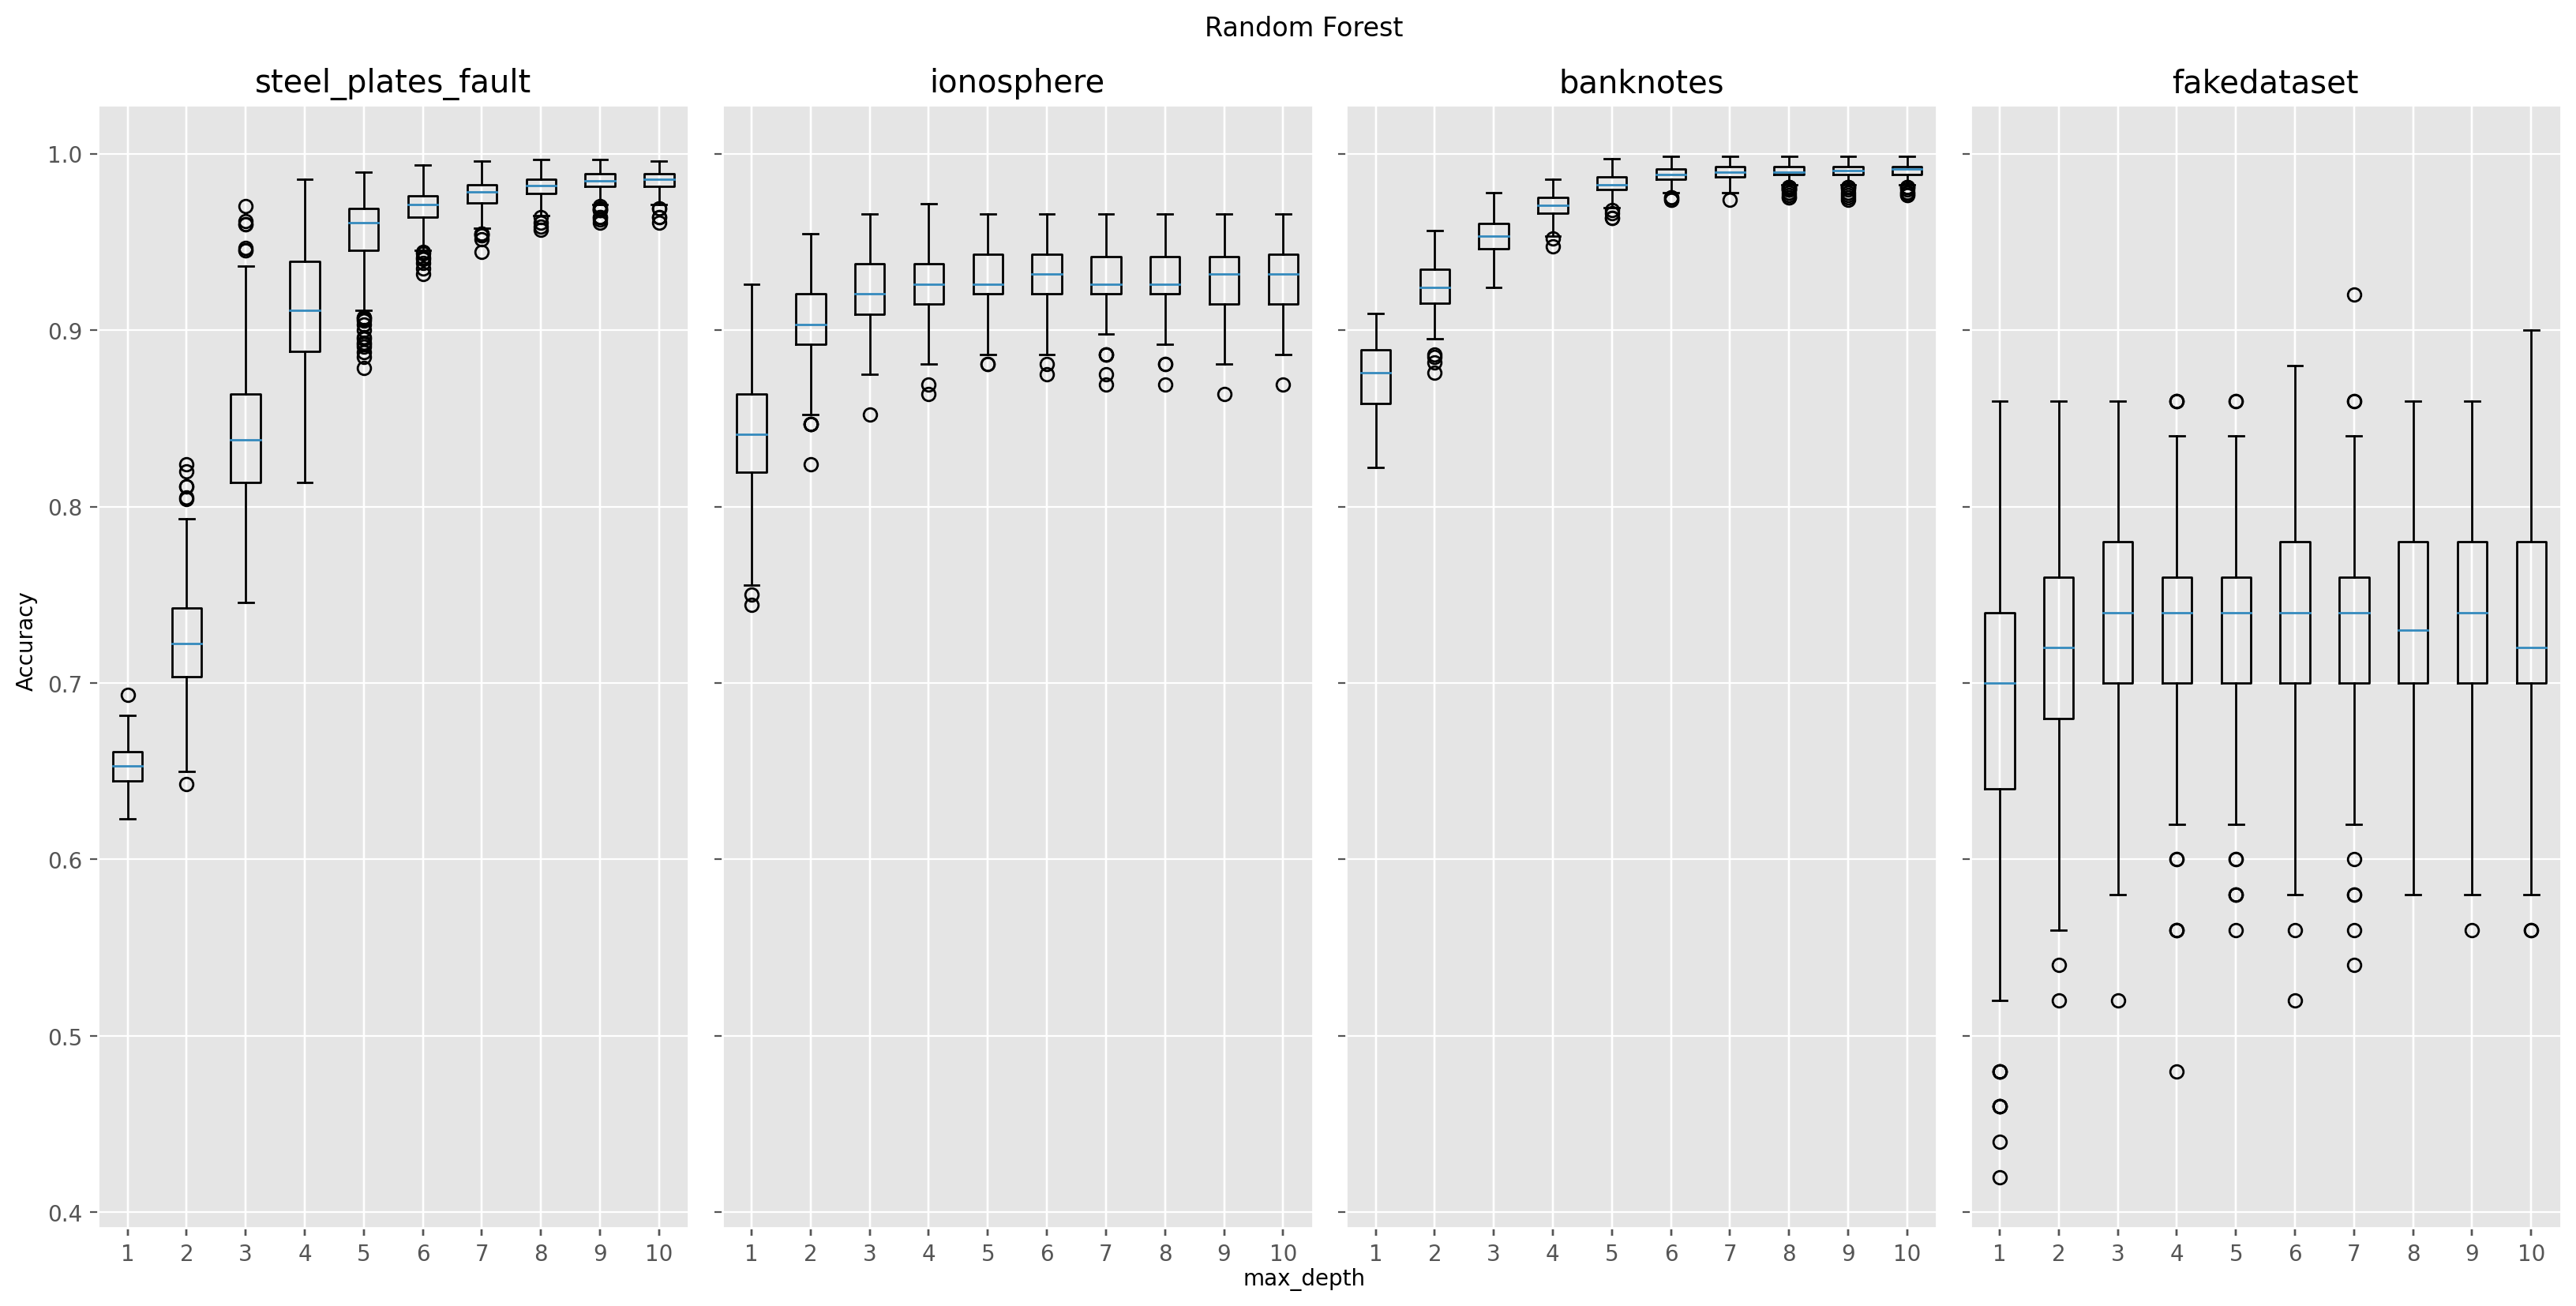

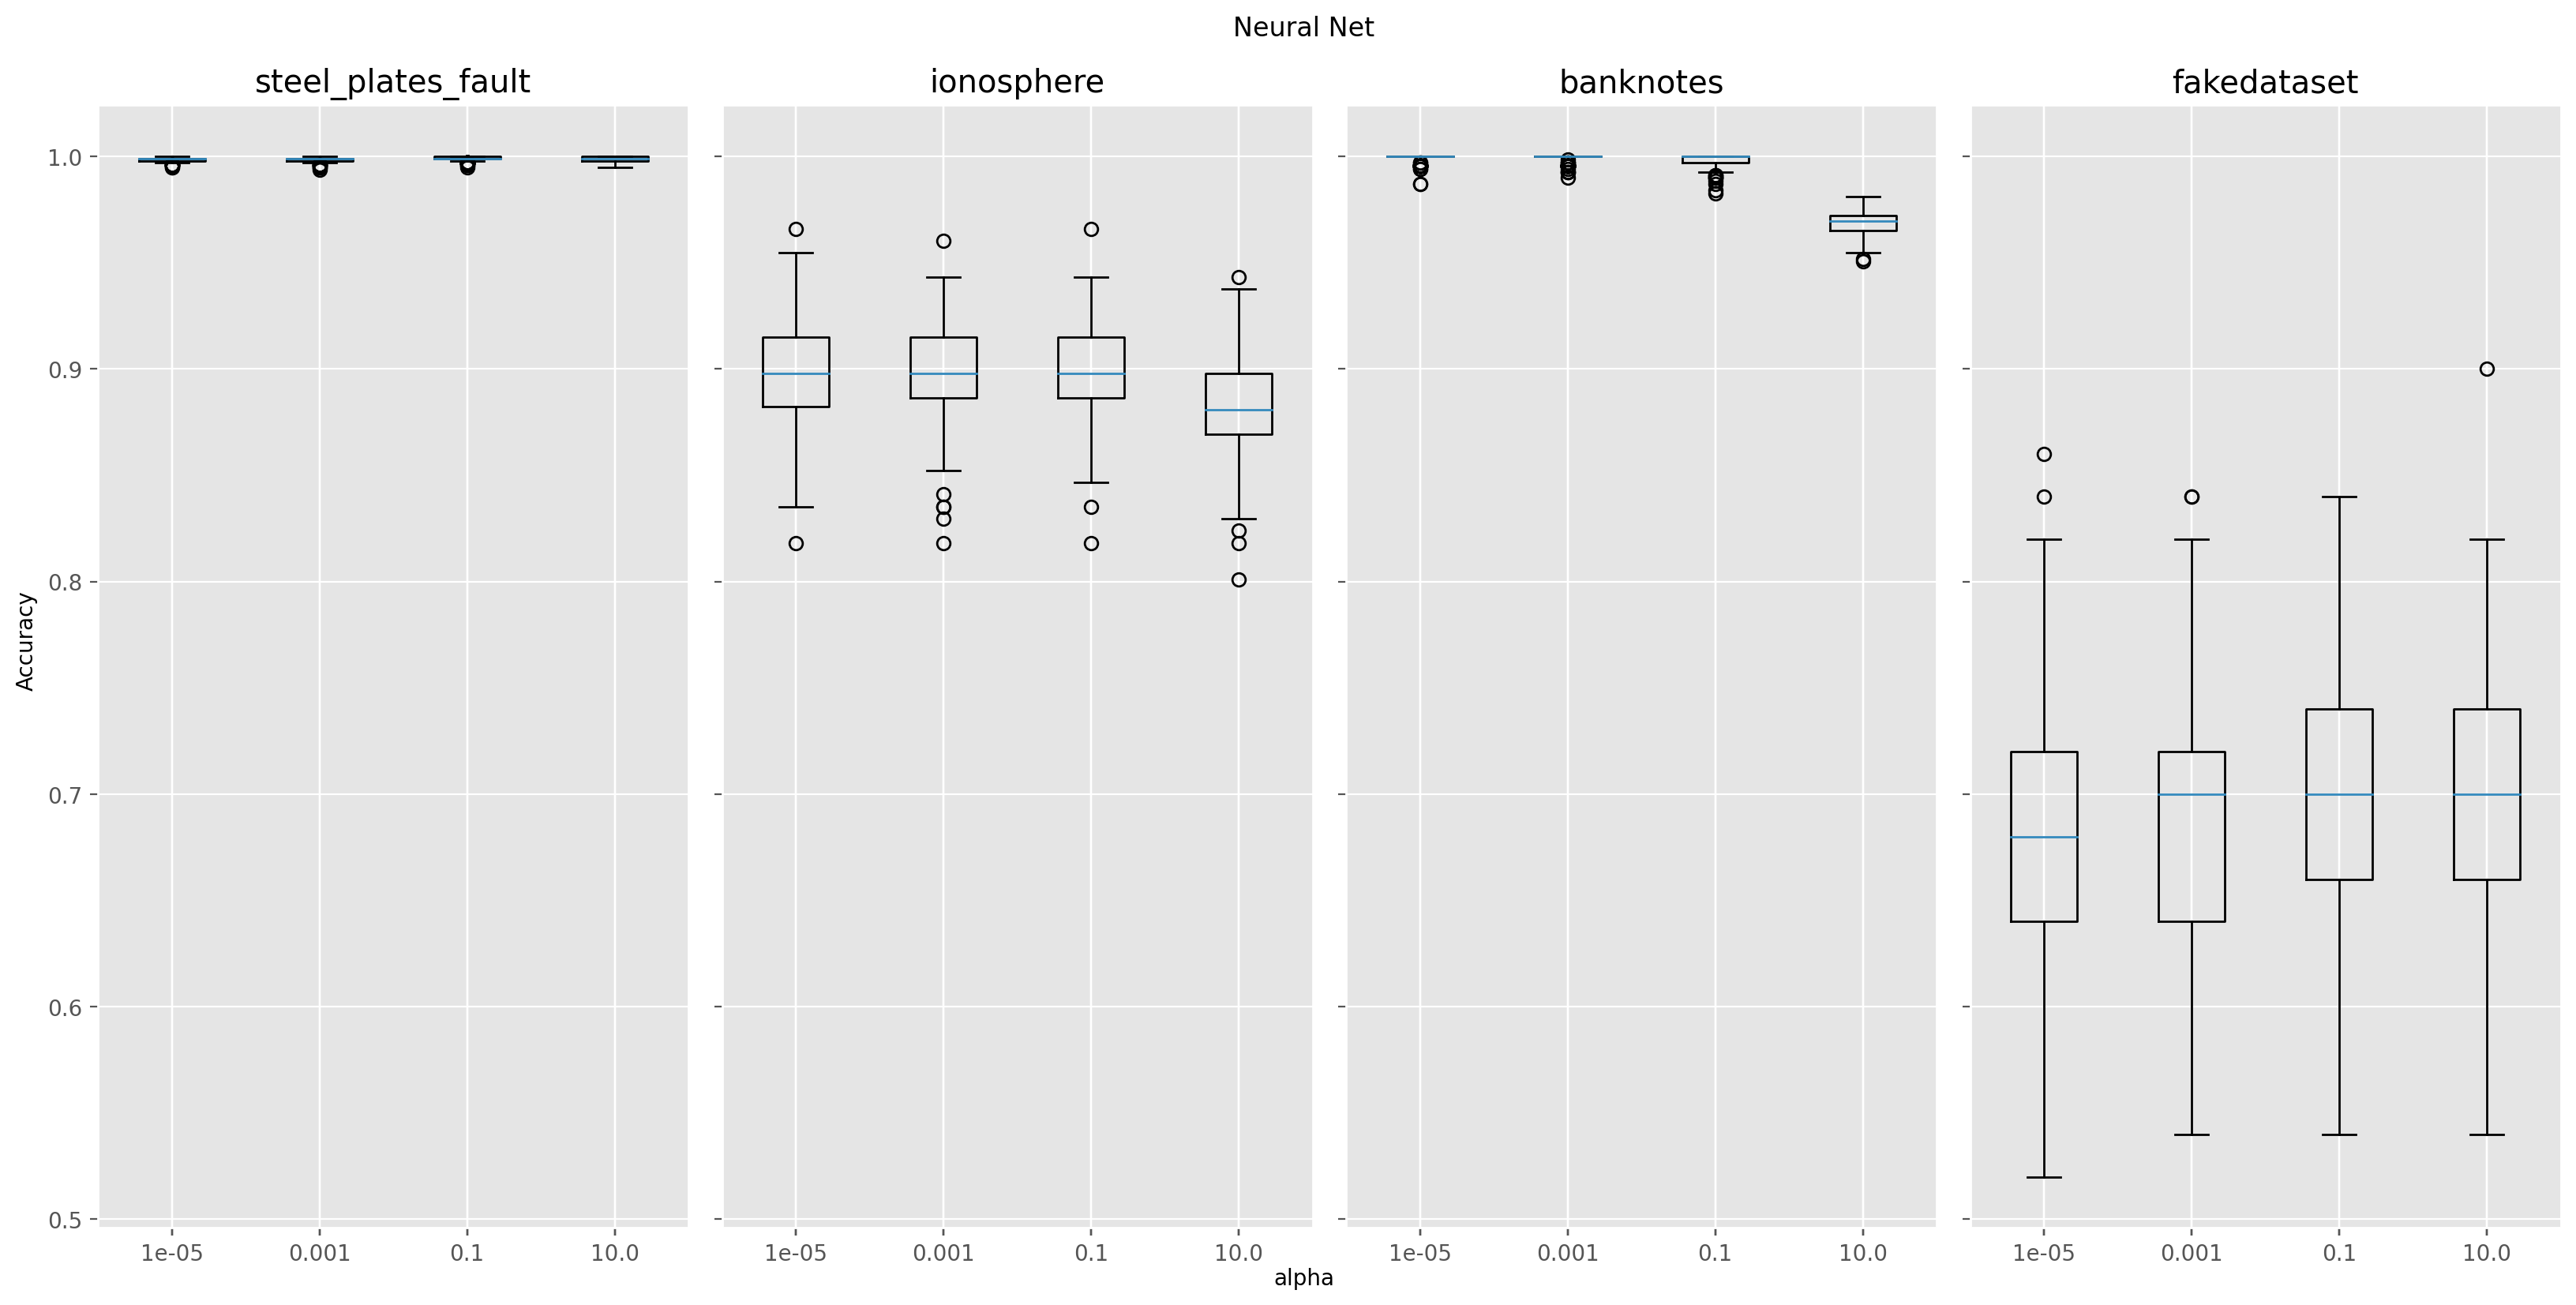

In [ ]:
#make use of the full screen width
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['figure.dpi'] = 200
j=0
#iterate over all algorithms (one row of charts per algo)
for n in algonames:
  #find all the results related to this algorithm
  results = [res for res in resultlist if res[1] == n]
  i=0
  #initialize a subplot figure layout
  fig, ax=plt.subplots(1,4,constrained_layout=True,sharex=True, sharey=True,)
  fig.suptitle(n)  
  fig.text(0.5, -0.01, list(param_grid_list[j][0].keys())[0], ha='center')
  fig.text(-0.01, 0.5, 'Accuracy', va='center', rotation='vertical')
  #iterate over data set results for a particular algorithm
  for subres in results:
    #find the test scores of the 250 iterations of cross validation for the different parameter settings
    intermedres = pd.DataFrame(subres[2].cv_results_)
    mask = intermedres.columns.str.contains('split.*_test_score')
    intermedres=intermedres.loc[:,mask] # selects mask
    #create box plot
    ax[i].boxplot(intermedres)
    ax[i].set_title(subres[0])
    ax[i].set_xticklabels(list(param_grid_list[j][0].values())[0])
    i += 1
    #plt.tight_layout()
  plt.show()
  j += 1


# Additional commentary based on summary tables
I'm iterating over the result list and pull out all results for a particular algorithm (one by one) and extract mean_test_score,rank_test_score,params and then select the highest ranking results for each algorithm. I calculate 1-score (accuracy) to get the error rate (as per instructions of the assignement).


In [ ]:
#iterate over all algorithms (one row of charts per algo)
table1={}
table2={}

for n in algonames:
  table1[n]={}
  table2[n]={}
  #find all the results related to this algorithm
  results = [res for res in resultlist if res[1] == n] 
  #iterate over data set results for a particular algorithm
  for subres, dn in zip(results,datasetnames):
    #find the parameter value with the best average test score
    intermedres = pd.DataFrame(subres[2].cv_results_)[['mean_test_score','rank_test_score','params']] 
    firstscore=1-intermedres[intermedres['rank_test_score']==1]['mean_test_score']
    firstparam=intermedres[intermedres['rank_test_score']==1]['params']
    #fill two dictionaries for screen print
    table1[n][dn]=np.array2string(firstscore.values)
    table2[n][dn]=pd.DataFrame(firstparam.values).to_string(index=False,header=False)
#screenprint dictionaries converted to data frame
t=pd.DataFrame.from_dict(table1).T
print('TABLE 1 = best average accuracy')
print(tabulate(t,headers=t.columns,tablefmt="fancy_grid"))

t=pd.DataFrame.from_dict(table2).T
print('\n\n TABLE 2 = best control parameter')
print(tabulate(t,headers=t.columns,stralign='right',tablefmt="fancy_grid"))


TABLE 1 = best average accuracy
╒══════════════════════════════════╤═════════════════════════════════╤══════════════╤═════════════╤═══════════════╕
│                                  │ steel_plates_fault              │ ionosphere   │ banknotes   │ fakedataset   │
╞══════════════════════════════════╪═════════════════════════════════╪══════════════╪═════════════╪═══════════════╡
│ k nearest neighbours             │ [0.02]                          │ [0.12]       │ [0.]        │ [0.35]        │
├──────────────────────────────────┼─────────────────────────────────┼──────────────┼─────────────┼───────────────┤
│ Gaussian Naive Bayes             │ [0.]                            │ [0.12 0.12]  │ [0.16 0.16] │ [0.27]        │
├──────────────────────────────────┼─────────────────────────────────┼──────────────┼─────────────┼───────────────┤
│ Perceptron (logistic regression) │ [0.]                            │ [0.13]       │ [0.02]      │ [0.3]         │
├──────────────────────────────────┼────

Results commentary Table 1: 
Based on the results it seems like the steel_plates_fault data is (on average) the easiest to separate into classes, followed by the banknotes data set, the ionosphere data set and finally the fake data set for which all algorithms struggled a bit (due to the noise we added to the data set during its creation).

Non surprisingly there is not single algorithm that dominates all other algorithms across all data sets.

It is interesting to note that there are several instances where various parameter settings lead to the same average validation error. The effect is most pronounced for the decision tree and the gradient boosted decision trees applied to the steel_plates_fault data set, but also occurs for the Gaussian Naive Bayes model applied to the last 3 data sets.

One might add here, that simply looking at the average error isn't the full picture, as the result might still differ in the standard deviation of that error distribution. Between similar average validation errors, one might prefer the parameter setting with the smaller standard deviation in the error distributionas it would deliver more consistent results across various splits of training and test sets.

Results commentary Table 1: 
there is (non-surprisingly) also not one single parameter setting (for any of the models) that dominates all other parameter settings across all data sets.



#Part II
Running 3 cluster k-means over the Iris dataset and 2 cluster k-means over the banknotes data set. 
Perform 250 iterations of 5%:95% cross-validation while training a GaussianNB classifier.
Train on X without clustering results and also on X' with clusting results included.
Plot test scores from both approaches against each other in scatter plot.

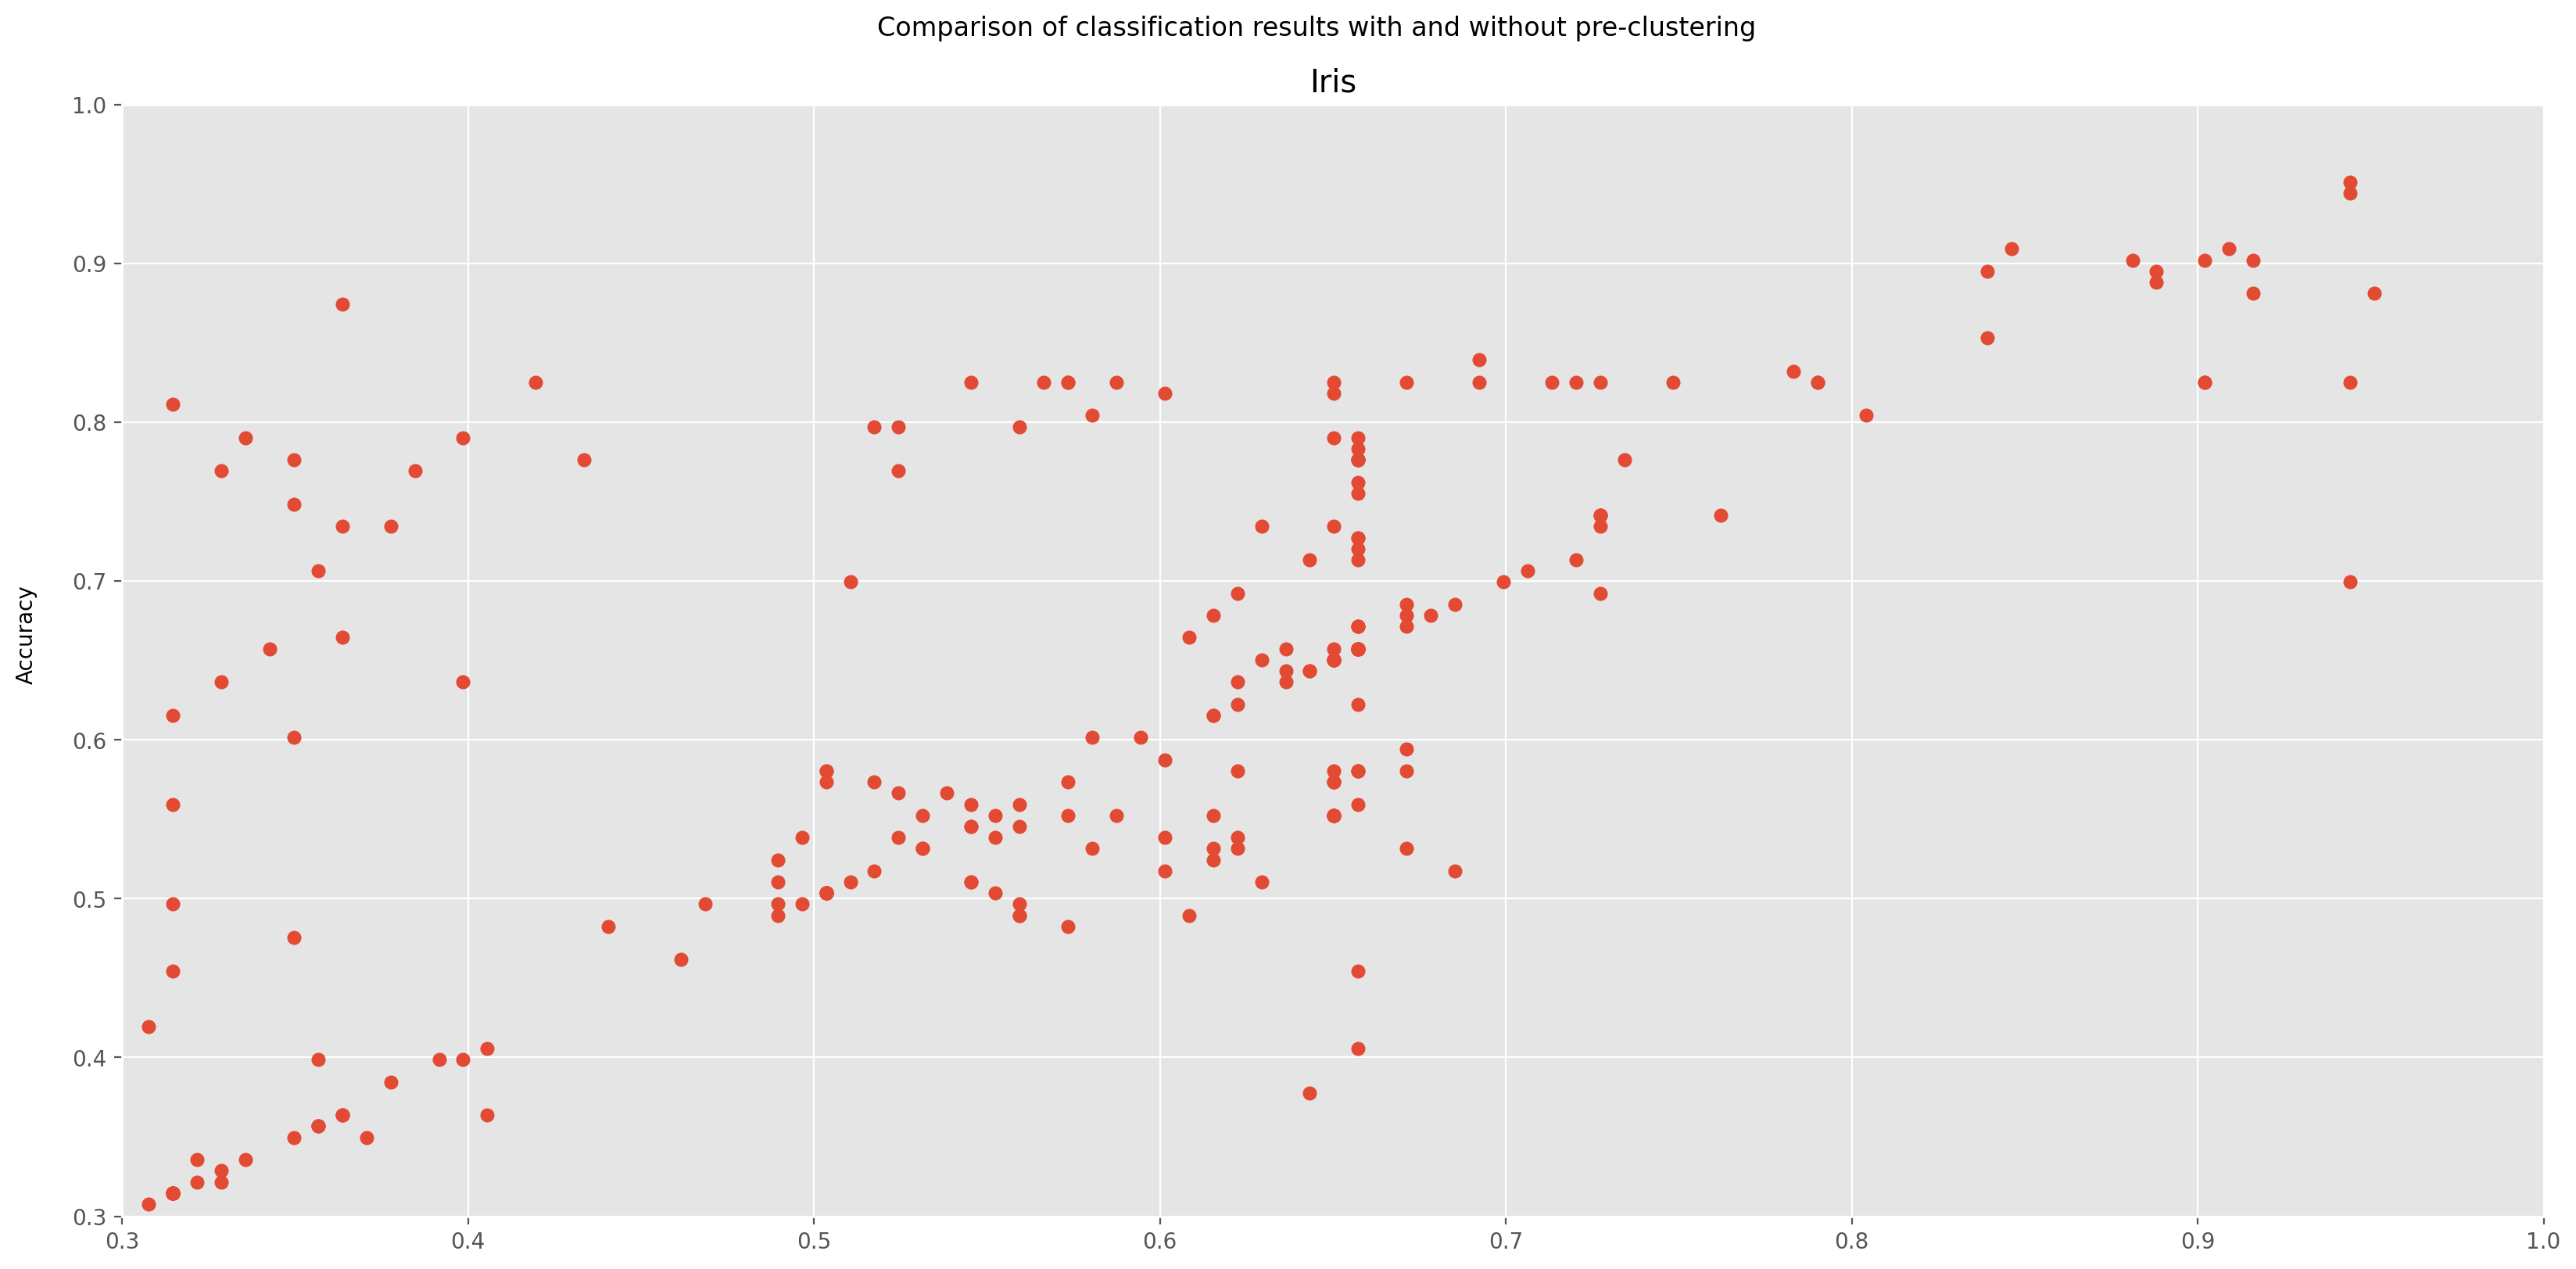

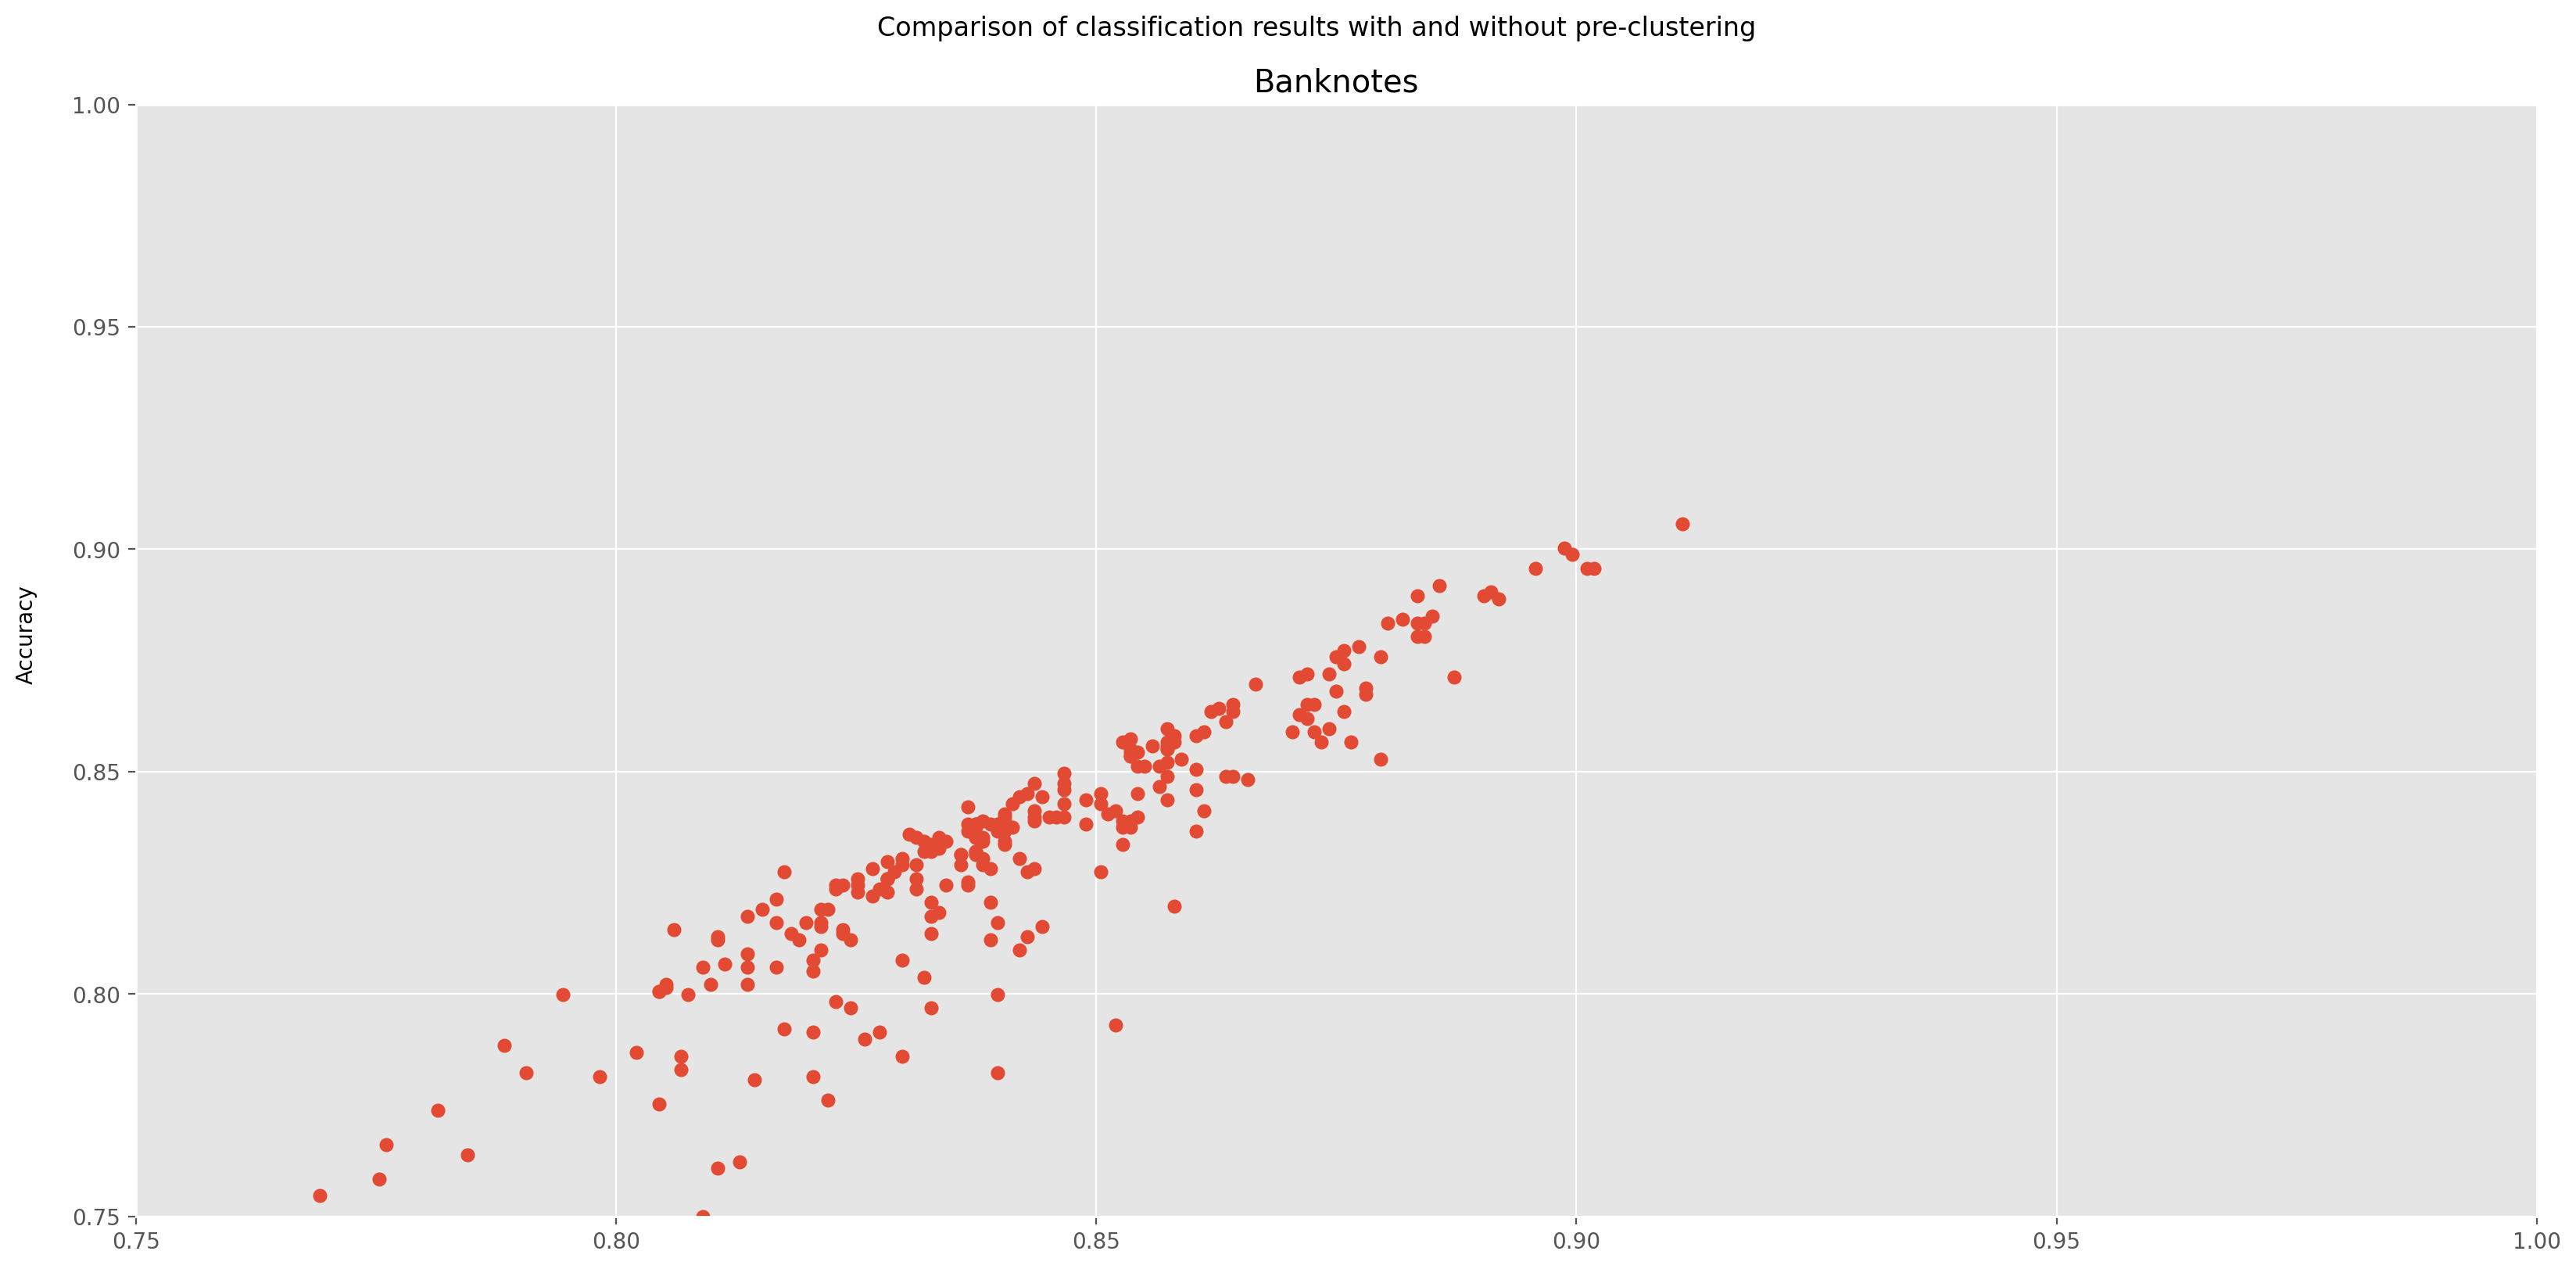

In [ ]:
X=iris.iloc[:, :-1]
Y=iris.iloc[:, -1]
#Standardize features by removing the mean and scaling to unit variance
#and perform 3 cluster k-means clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(StandardScaler().fit_transform(X))
X['labels'] = kmeans.labels_
#perform cross validation 250 times 0.05:0.95
cv = ShuffleSplit(n_splits=250, test_size=0.95, random_state=0) 
nb = GaussianNB()
params = {}
#Train Gaussian NB on X without cluster information as well as X with cluster information
gsres_withclust = GridSearchCV(estimator=nb, cv=cv, param_grid=params,verbose=0,n_jobs=-1,scoring='accuracy').fit(X,Y)
gsres_without_clust = GridSearchCV(estimator=nb, cv=cv, param_grid=params,verbose=0,n_jobs=-1,scoring='accuracy').fit(X.iloc[:,:-1],Y)
#scatter plot the results
fig, ax=plt.subplots(1,1,constrained_layout=True,sharex=True, sharey=True,)
fig.suptitle('Comparison of classification results with and without pre-clustering')  
fig.text(-0.02, 0.5, 'Accuracy', va='center', rotation='vertical')
  
intermedres_withclust = pd.DataFrame(gsres_withclust.cv_results_)
intermedres_without_clust = pd.DataFrame(gsres_without_clust.cv_results_)

mask = intermedres_withclust.columns.str.contains('split.*_test_score')
intermedres_withclust=intermedres_withclust.loc[:,mask] # selects mask
mask = intermedres_without_clust.columns.str.contains('split.*_test_score')
intermedres_without_clust=intermedres_without_clust.loc[:,mask] # selects mask

ax.scatter(intermedres_without_clust, intermedres_withclust)
ax.set_title('Iris')
plt.xlim(0.3, 1)
plt.ylim(0.3, 1)

#All steps below are identical to above apart from k=2. 

X=banknotes.iloc[:, :-1]
Y=banknotes.iloc[:, -1]
kmeans = KMeans(n_clusters=2, random_state=0).fit(StandardScaler().fit_transform(X))
X['labels'] = kmeans.labels_
cv = ShuffleSplit(n_splits=250, test_size=0.95, random_state=0) 
nb = GaussianNB()
params = {}
gsres_withclust = GridSearchCV(estimator=nb, cv=cv, param_grid=params,verbose=0,n_jobs=-1,scoring='accuracy').fit(X,Y)
gsres_without_clust = GridSearchCV(estimator=nb, cv=cv, param_grid=params,verbose=0,n_jobs=-1,scoring='accuracy').fit(X.iloc[:,:-1],Y)
  
fig, ax=plt.subplots(1,1,constrained_layout=True,sharex=True, sharey=True,)
fig.suptitle('Comparison of classification results with and without pre-clustering')  
fig.text(-0.02, 0.5, 'Accuracy', va='center', rotation='vertical')
  
intermedres_withclust = pd.DataFrame(gsres_withclust.cv_results_)
intermedres_without_clust = pd.DataFrame(gsres_without_clust.cv_results_)

mask = intermedres_withclust.columns.str.contains('split.*_test_score')
intermedres_withclust=intermedres_withclust.loc[:,mask] # selects mask
mask = intermedres_without_clust.columns.str.contains('split.*_test_score')
intermedres_without_clust=intermedres_without_clust.loc[:,mask] # selects mask

ax.scatter(intermedres_without_clust, intermedres_withclust)
ax.set_title('Banknotes')
plt.xlim(0.75, 1)
plt.ylim(0.75, 1)
plt.show()


##Discussion of results (pre-classification K-means clustering)
### Iris
In case of the Iris data set, the pre-classification clustering is benefitial to the classification results. 
In the case of the scatter plot for the Iris data-set a lot of point are located above the diagonal. And many sit around 80% accuracy for the classification results that make use of pre-clustering. In a way the results are not too surprising, given that we "snooped" into the test data during the pre-clustering, as the clusters were learnt on the full data set. Given the small training data sets (5% of all data points) there is a good chance these training samples are not fully representative of the overall data set. So if we were to train a classifier on such samples it might be equally off the mark. By adding the cluster information from a clustering of the whole data set we allow classifier to take on board features that are less dependent on the question if a sample is representative of it's class. E.g. a data point could be at the "fringes" of a class or cluster and therefore be highly non-representative about the cluster/class center in the feature space, but as long as it carries the "right" cluster ID (with the assumptions that cluster boundaries sufficiently over lap or represent class boundaries) it wouldn't matter. Through the pre-classification clustering we almost get a noisy representations of class labels into the feature space (particularly if we force the number of clusters to be equal the number of classes).

###Banknotes
The results for the bank notes data set are that the pre-clusting is non-beneficial as in the scatter plot more points are below the diagonal. This as well is not partcularly surprising as we wouldn't expect the class of forged bank notes to be particularly homogenous in the feature space. One would imagine that forgers differ in how their forgeries differ from an orginial. The problem at hand is more like anomalie detection. There is a more or less homogenous class of original bank notes (admittedly an assumption as there might be several different clusters or sub-classes linked to the class of original bank notes) and then there is "the rest" = forgeries. It is not known upfront how many clusters would represent this data set best and one would have to find that out by trial and error. Forcing two clusters will most likely split the data set into two clusters with cluster boundaries badly allgining with class boundaries. So we actually add bad / noisy features. Maybe DBSCAN could perform better here?

#AIML class additional assignement question
Running 3 component PCA over the Iris and banknotes dataset Perform 250 iterations of 5%:95% cross-validation while training a GaussianNB classifier. Train on X without PCA results and also on X' with PCA results included. Plot test scores from both approaches against each other in scatter plot.

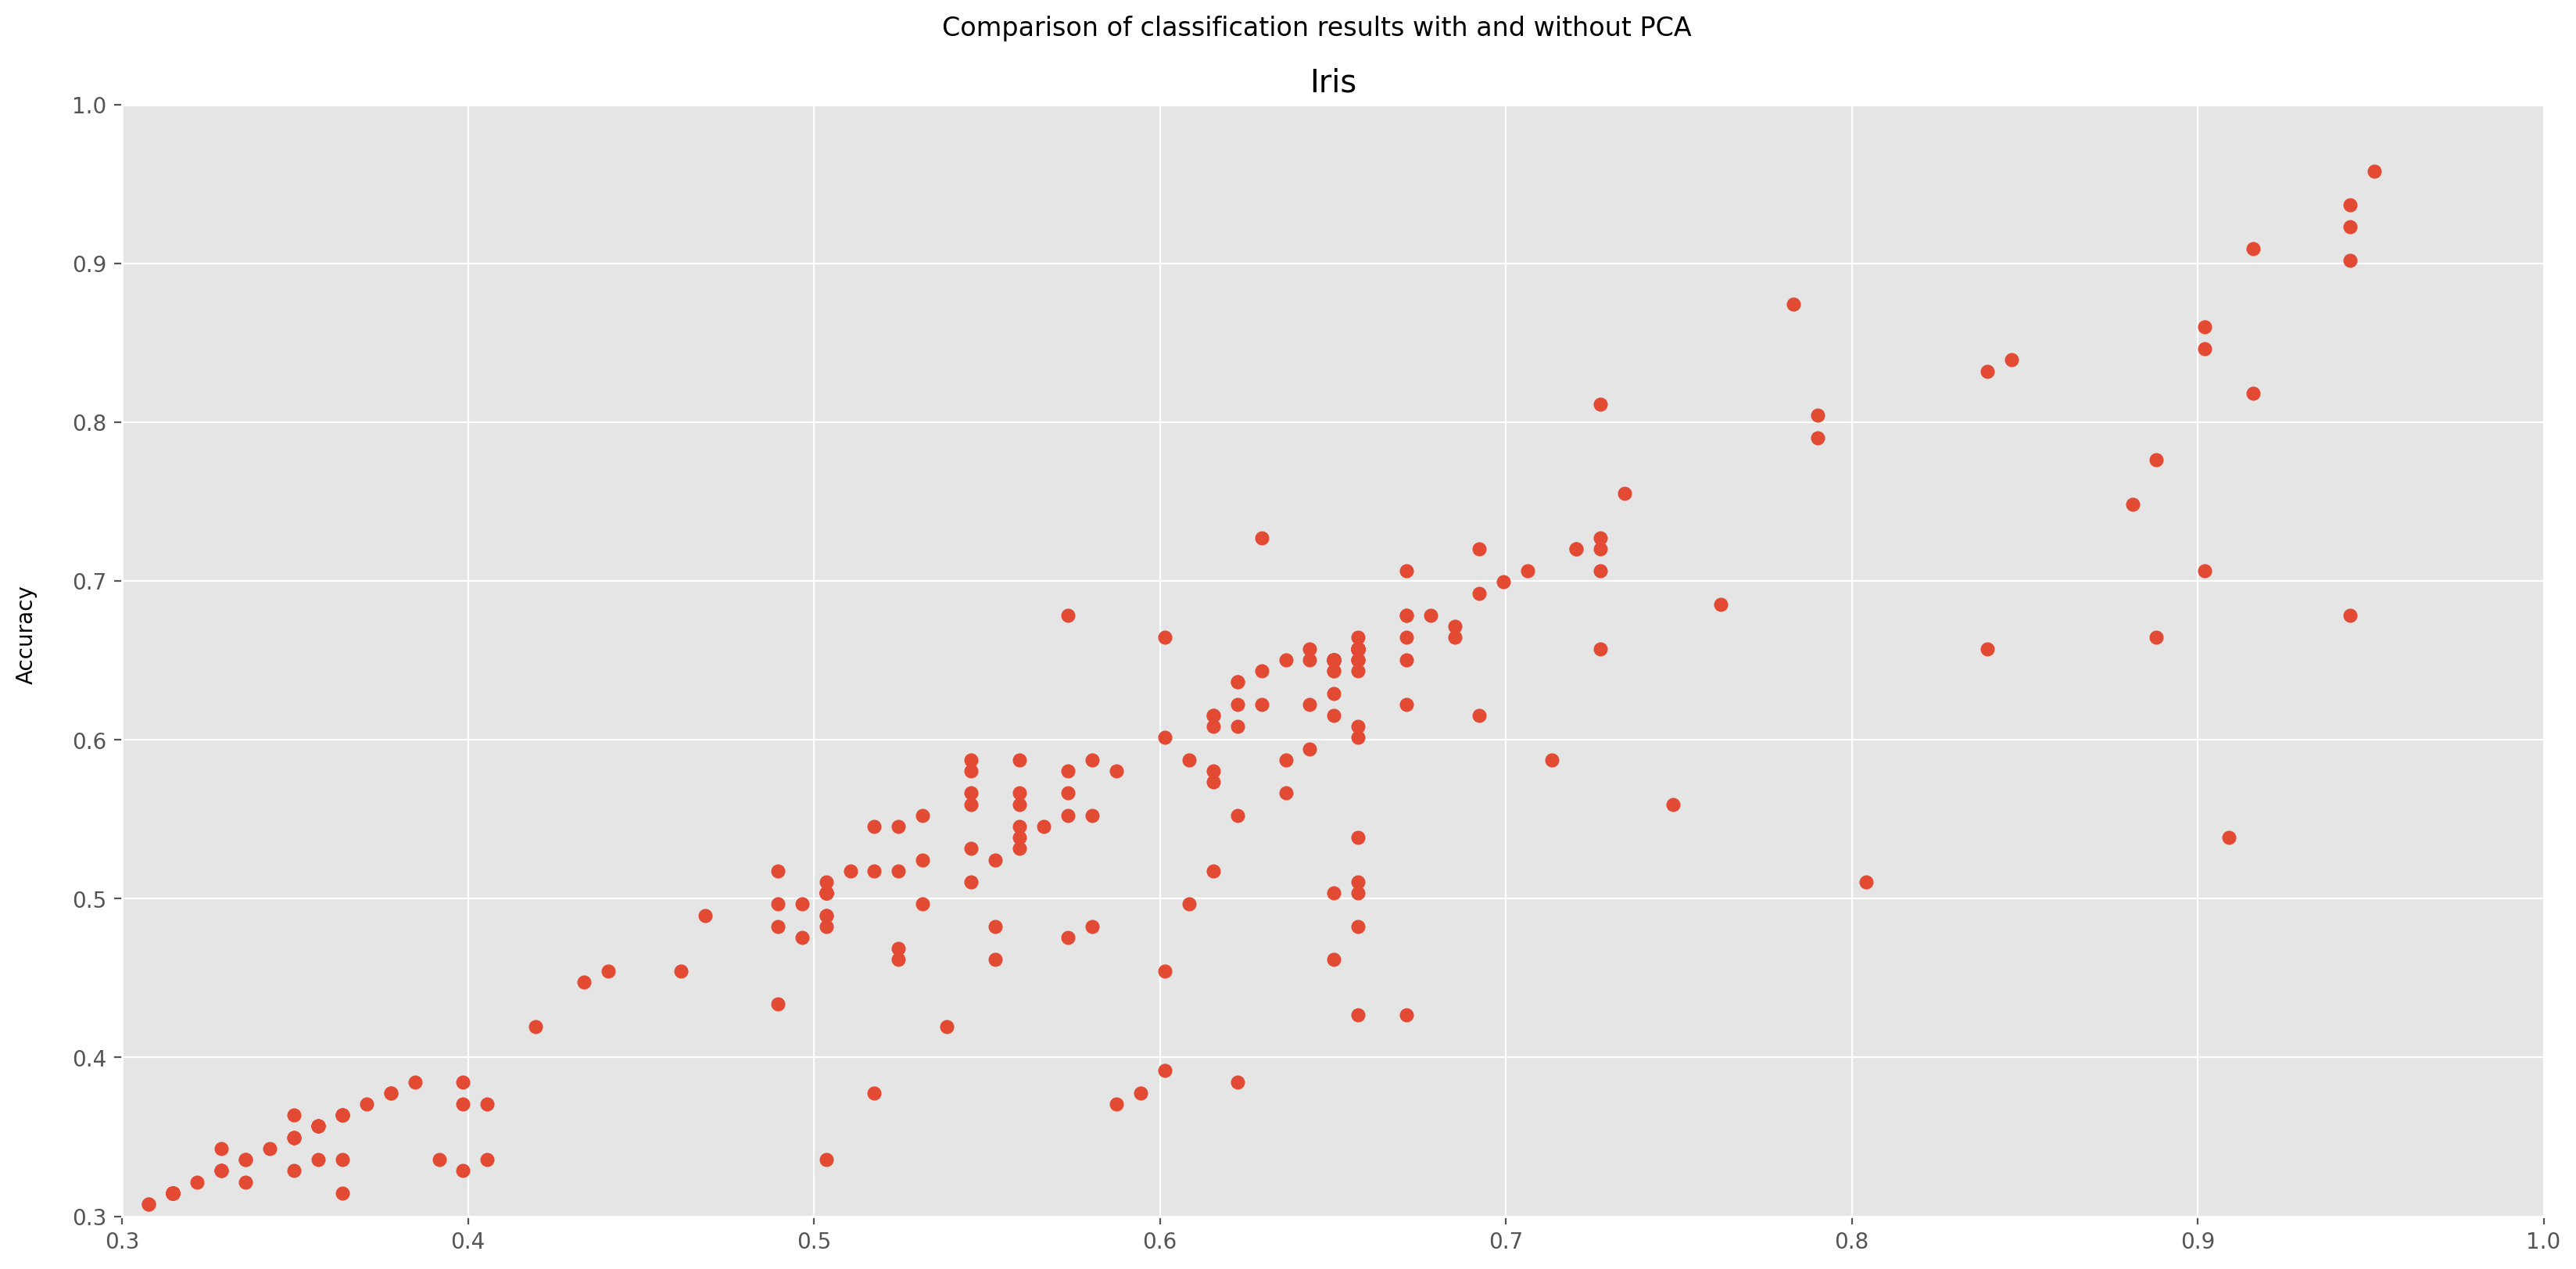

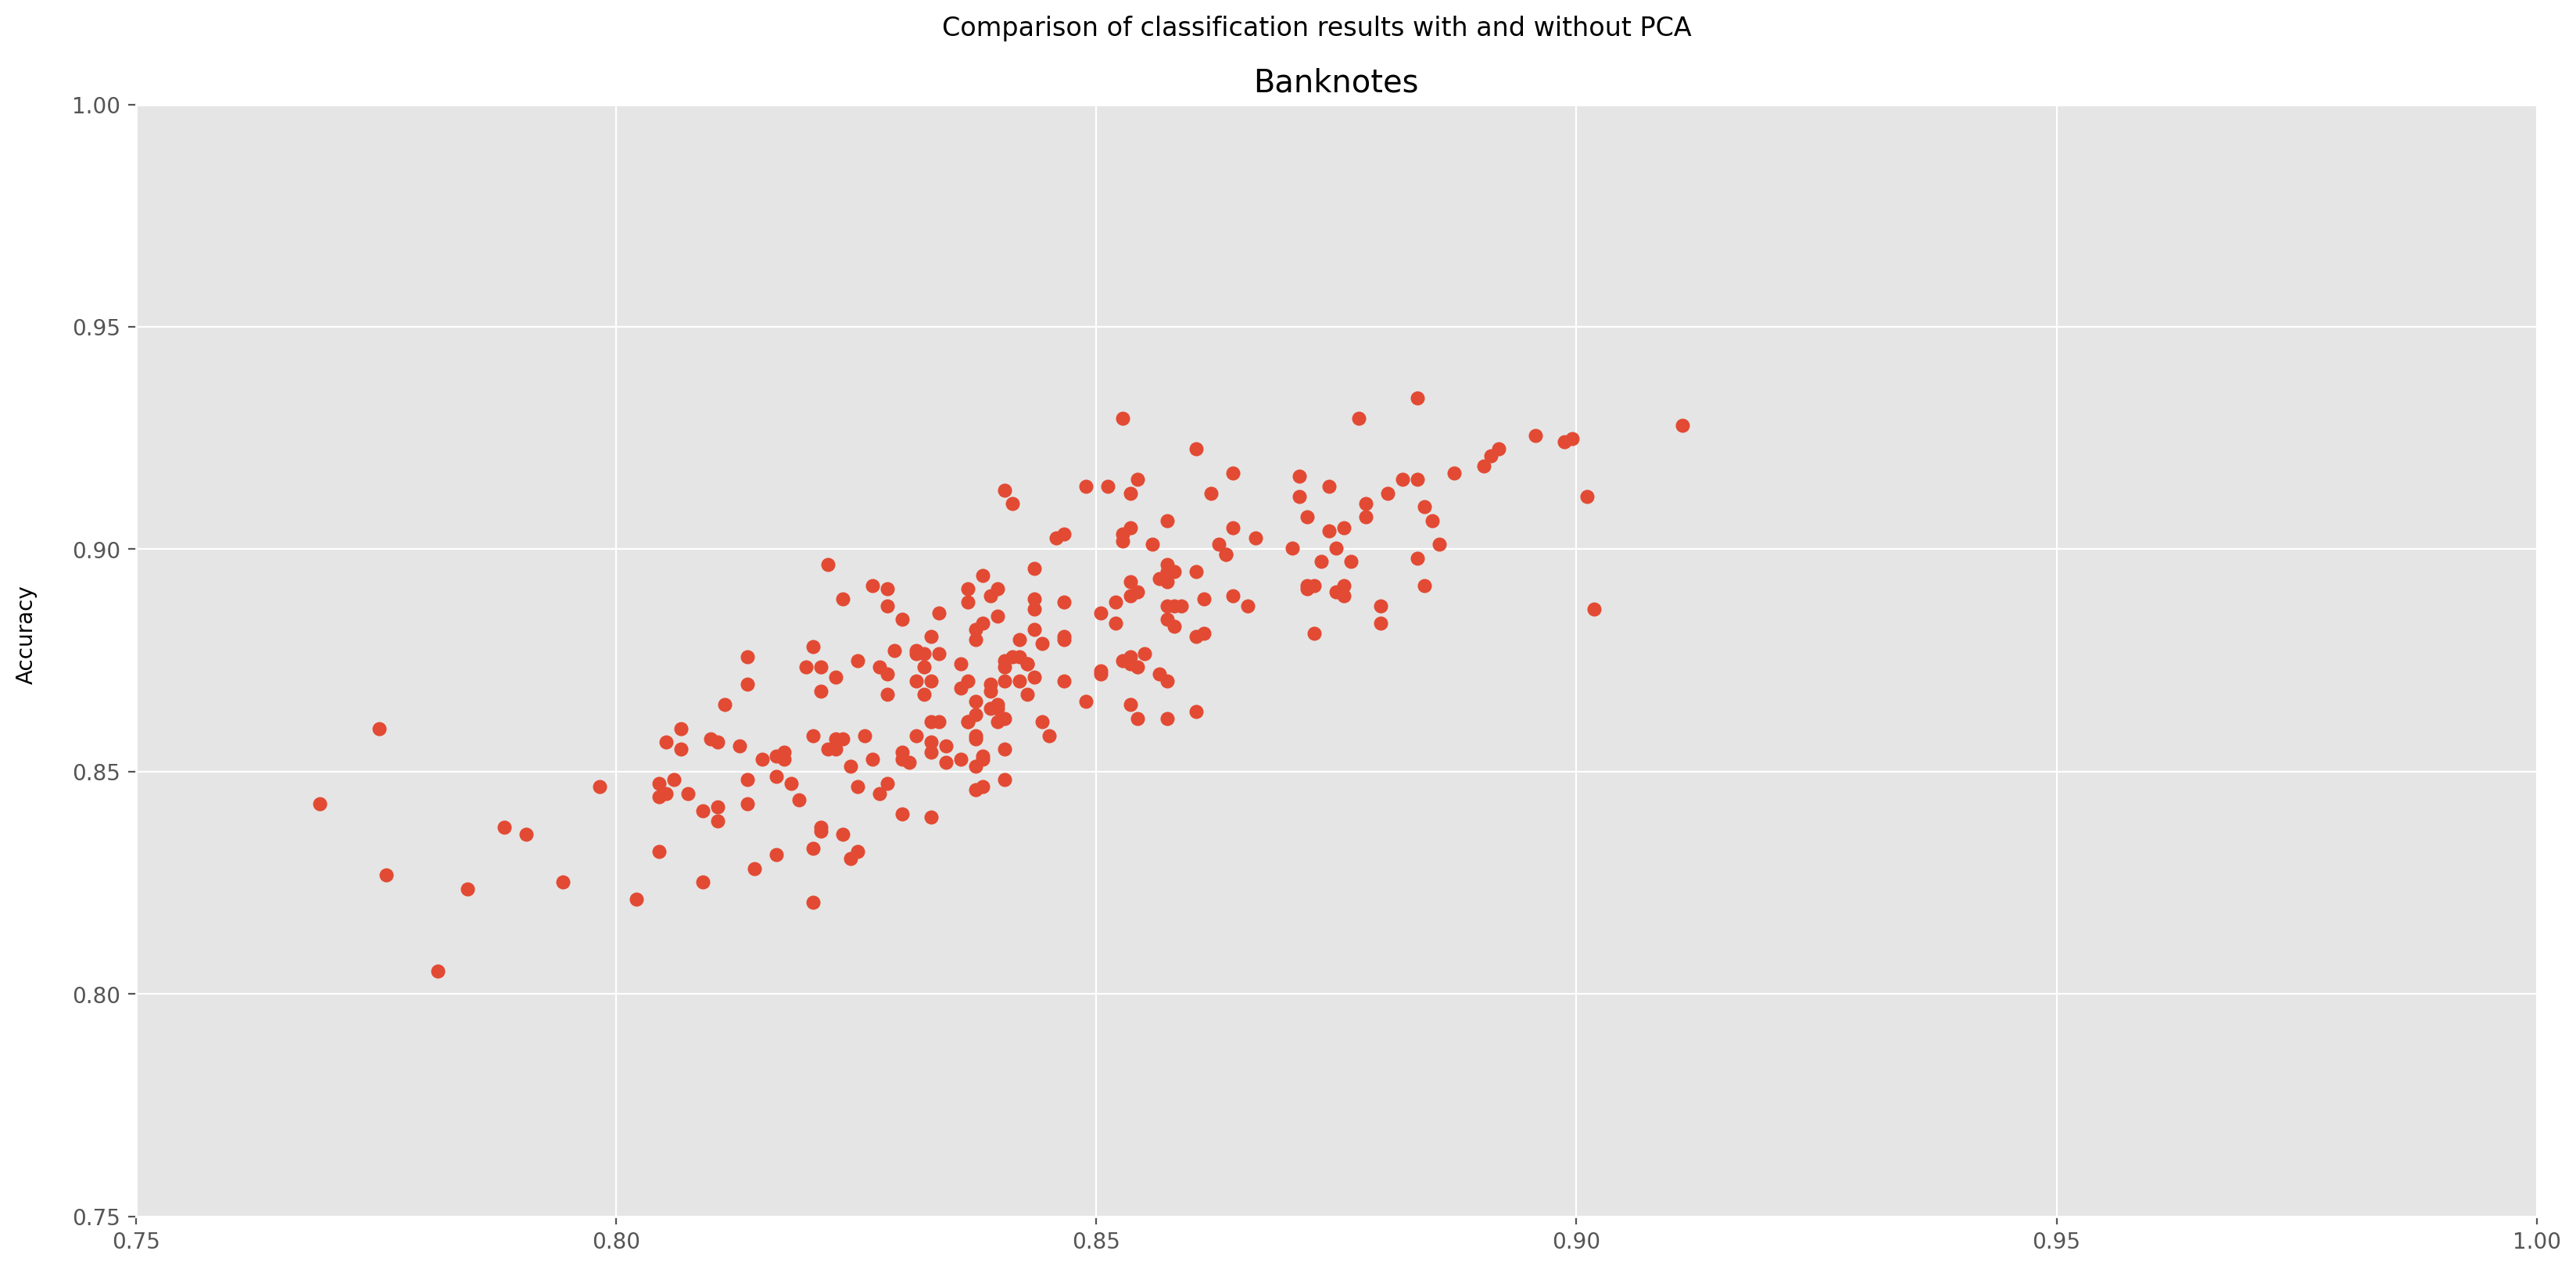

In [ ]:
X= StandardScaler().fit_transform(iris.iloc[:, :-1])
Y=iris.iloc[:, -1]
#fitting 3 component PCA to data set
pca = PCA(n_components = 3)
principalComponents = pd.DataFrame(pca.fit_transform(X))
X = pd.concat([pd.DataFrame(X),principalComponents], axis = 1)
#perform cross validation 250 times 0.05:0.95
cv = ShuffleSplit(n_splits=250, test_size=0.95, random_state=0) 
nb = GaussianNB()
params = {}
#Train Gaussian NB on X without cluster information as well as X with cluster information
gsres_withpca = GridSearchCV(estimator=nb, cv=cv, param_grid=params,verbose=0,n_jobs=-1,scoring='accuracy').fit(X,Y)
gsres_without_pca = GridSearchCV(estimator=nb, cv=cv, param_grid=params,verbose=0,n_jobs=-1,scoring='accuracy').fit(X.iloc[:,:-3],Y)
#scatter plot the results
fig, ax=plt.subplots(1,1,constrained_layout=True,sharex=True, sharey=True,)
fig.suptitle('Comparison of classification results with and without PCA')  
fig.text(-0.02, 0.5, 'Accuracy', va='center', rotation='vertical')
  
intermedres_withpca = pd.DataFrame(gsres_withpca.cv_results_)
intermedres_without_pca = pd.DataFrame(gsres_without_pca.cv_results_)

mask = intermedres_withpca.columns.str.contains('split.*_test_score')
intermedres_withpca=intermedres_withpca.loc[:,mask] # selects mask
mask = intermedres_without_pca.columns.str.contains('split.*_test_score')
intermedres_without_pca=intermedres_without_pca.loc[:,mask] # selects mask

ax.scatter(intermedres_without_pca, intermedres_withpca)
ax.set_title('Iris')
plt.xlim(0.3, 1)
plt.ylim(0.3, 1)

#follow steps exactly as above but for banknotes data set
X= StandardScaler().fit_transform(banknotes.iloc[:, :-1])
Y=banknotes.iloc[:, -1]
pca = PCA(n_components = 3)
principalComponents = pd.DataFrame(pca.fit_transform(X))
X = pd.concat([pd.DataFrame(X),principalComponents], axis = 1)

cv = ShuffleSplit(n_splits=250, test_size=0.95, random_state=0) 
nb = GaussianNB()
params = {}
gsres_withpca = GridSearchCV(estimator=nb, cv=cv, param_grid=params,verbose=0,n_jobs=-1,scoring='accuracy').fit(X,Y)
gsres_without_pca = GridSearchCV(estimator=nb, cv=cv, param_grid=params,verbose=0,n_jobs=-1,scoring='accuracy').fit(X.iloc[:,:-3],Y)
  
fig, ax=plt.subplots(1,1,constrained_layout=True,sharex=True, sharey=True,)
fig.suptitle('Comparison of classification results with and without PCA')  
fig.text(-0.02, 0.5, 'Accuracy', va='center', rotation='vertical')
  
intermedres_withpca = pd.DataFrame(gsres_withpca.cv_results_)
intermedres_without_pca = pd.DataFrame(gsres_without_pca.cv_results_)

mask = intermedres_withpca.columns.str.contains('split.*_test_score')
intermedres_withpca=intermedres_withpca.loc[:,mask] # selects mask
mask = intermedres_without_pca.columns.str.contains('split.*_test_score')
intermedres_without_pca=intermedres_without_pca.loc[:,mask] # selects mask

ax.scatter(intermedres_without_pca, intermedres_withpca)
ax.set_title('Banknotes')
plt.xlim(0.75, 1)
plt.ylim(0.75, 1)
plt.show()

##Discussion of results (pre-classification PCA)
### Iris
The classification results based on PCA (with 3 components) is non-beneficial as more data points are located under the diagonal in the scatter plot of the test scores. My hypothesis to explain this is that the axes of maximum variation in the feature space (which is what PCA focusses on) is not alligned with the axes along which best class separation can be achieved.

###Banknotes
The classification results based on PCA (with 3 components) is beneficial as more data points are located over the diagonal in the scatter plot of the test scores. My hypothesis to explain this is that the axes of maximum variation in the feature space (which is what PCA focusses on) is relatively well alligned with the axes along which best class separation can be achieved.